In [2]:
%matplotlib inline
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import tensorflow as tf
import numpy as np
import librosa
from utils.strechableNumpyArray import StrechableNumpyArray
import matplotlib.pyplot as plt
import IPython
import functools
from tensorflow.contrib.signal.python.ops import window_ops


from system.lstmSystem import LSTMSystem
from architecture.realImagContextEncoderLSTMArchitecture import RealImagContextEncoderLSTMArchitecture
from system.preAndPostProcessor import PreAndPostProcessor

In [3]:
import importlib
import system
importlib.reload(system.lstmSystem)
from system.lstmSystem import LSTMSystem
import architecture
importlib.reload(architecture.realImagContextEncoderLSTMArchitecture)
from architecture.realImagContextEncoderLSTMArchitecture import RealImagContextEncoderLSTMArchitecture
import system
importlib.reload(system.preAndPostProcessor)
from system.preAndPostProcessor import PreAndPostProcessor

from architecture.contextEncoderLSTMArchitecture import ContextEncoderLSTMArchitecture
importlib.reload(architecture.contextEncoderLSTMArchitecture)
from architecture.contextEncoderLSTMArchitecture import ContextEncoderLSTMArchitecture

from system.lstmSystem import LSTMSystem

In [4]:
tf.reset_default_graph()

from architecture.parameters.lstmContextInpaintingParameters import LstmContextInpaintingParameters
from architecture.realImagContextEncoderLSTMArchitecture import RealImagContextEncoderLSTMArchitecture
import os

from system.preAndPostProcessor import PreAndPostProcessor
from system.realImagContextLSTMSystem import RealImagContextLSTMSystem
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

sessionsName = "test_b256_fft256_"

params = LstmContextInpaintingParameters(lstmSize=512, batchSize=64, signalLength=2048*2+1024, inputChannels=4,
										 gapLength=1024, fftWindowLength=256, fftHopSize=64)

contextArchitecture = RealImagContextEncoderLSTMArchitecture(params)

aPreProcessor = PreAndPostProcessor(params)

aContextEncoderSystem = RealImagContextLSTMSystem(contextArchitecture, aPreProcessor, params, sessionsName)


In [5]:
sr = 16000
start_in_seconds = 0.1
gap_length = 1024
side_length = 2048

starting_sample_left_side = int(sr*start_in_seconds)
ending_sample_left_side = starting_sample_left_side + side_length
starting_sample_right_side = ending_sample_left_side + gap_length
ending_sample_right_side = starting_sample_right_side + side_length

best_step = 458000
batch_size = 64

In [6]:
pathToDatasetFolder = "../LSTMsOnSpectrograms/nsynth-test/audio"
audios = StrechableNumpyArray()
i = 0
total = 0
file_names = []
for file_name in os.listdir(pathToDatasetFolder):
    audio, sr = librosa.load(pathToDatasetFolder + '/' + file_name, sr=None)

    if np.sum(np.absolute(audio[5120:5120*2])) < 5120*1e-3: 
        print(file_name, "doesn't meet the minimum amplitude requirement")
        continue

    file_names.append(file_name)
    audios.append(audio)
    i+=1

    if i > 500:
        i -= 500
        total += 500
        print("500 plus!", total)
        break
#         if total >= 0 and i >= 8:
#             break
print("there were: ", total+i)

audios = audios.finalize()
audios = np.reshape(audios, (total+i, len(audio)))
print(audios.shape)

bass_electronic_018-022-100.wav doesn't meet the minimum amplitude requirement
bass_electronic_018-023-025.wav doesn't meet the minimum amplitude requirement
bass_electronic_025-022-050.wav doesn't meet the minimum amplitude requirement
bass_electronic_027-022-050.wav doesn't meet the minimum amplitude requirement
500 plus! 500
there were:  501
(501, 64000)


In [7]:
original_signals = audios[:, starting_sample_left_side:ending_sample_right_side]
original_gaps = audios[:, ending_sample_left_side:starting_sample_right_side]

In [8]:
generatedSpecs = aContextEncoderSystem.reconstruct(original_signals, model_num=best_step)

INFO:tensorflow:Restoring parameters from utils/saved_models/test_b256_fft256_/model-test_b256_fft256_458000.ckpt
Model restored.


In [10]:
generatedSpecs[2].shape

(448, 29, 129, 4)

In [40]:
complexGenerated = generatedSpecs[0][:, :, :, 0] + 1.0j * generatedSpecs[0][:, :, :, 1]
complexOriginal = generatedSpecs[1][:, :, :, 0] + 1.0j * generatedSpecs[1][:, :, :, 1]
complexContext = np.concatenate([generatedSpecs[2][:, :, :, 0] + 1.0j * generatedSpecs[2][:, :, :, 1],
                                 generatedSpecs[2][:, :, :, 2] + 1.0j * generatedSpecs[2][:, :, :, 3]],
                                axis=1)

# plotGeneratedSpecs = np.abs(complexGenerated)
# plotOriginalSpecs = np.abs(complexOriginal)
print(complexContext.shape)
print(generatedSpecs[0].shape)
# len(original_signals)

(448, 58, 129)
(448, 19, 129, 2)


In [35]:
print(np.mean(_pavlovs_SNR(generatedSpecs[0], generatedSpecs[1], onAxis=(1, 2, 3))))
print(np.mean(_pavlovs_SNR(np.abs(complexGenerated), np.abs(complexOriginal), onAxis=(1, 2))))
print(np.mean(_pavlovs_SNR(np.log10(np.abs(complexGenerated+1e-4)), np.log10(np.abs(complexOriginal+1e-4)), onAxis=(1, 2))))
magLogSpec = np.log10(np.maximum(np.abs(complexOriginal), 1e-4) + 1)
magGenSpec = np.log10(np.maximum(np.abs(complexGenerated), 1e-4) + 1)
print(np.mean(_pavlovs_SNR(magLogSpec, magGenSpec, onAxis=(1, 2))))

9.17644
9.63884
2.0405138
12.275399


In [262]:
testo = generatedSpecs[0][:, 1:] - generatedSpecs[0][:, :-1] 
testi = generatedSpecs[1][:, 1:] - generatedSpecs[1][:, :-1] 
print(np.mean(_pavlovs_SNR(testo, testi, onAxis=(1, 2, 3))))
np.sum(np.square(testo-testi))
print(np.max(testo))
print(np.max(testi))
print(np.min(testo))
print(np.min(testi))

9.565979
99.894745
118.27319
-99.577225
-117.765076


In [378]:
print(np.mean(_pavlovs_SNR(generatedSpecs[0], generatedSpecs[1], onAxis=(1, 2, 3))))
np.sum(np.square(generatedSpecs[0]-generatedSpecs[1]))
print(np.max(generatedSpecs[0]))
print(np.max(generatedSpecs[1]))
print(np.min(generatedSpecs[0]))
print(np.min(generatedSpecs[1]))

14.733728
235.00418
238.29144
-122.758835
-137.44472


In [11]:
params.contextStftFrameCount()

29.0

28.7335205078125


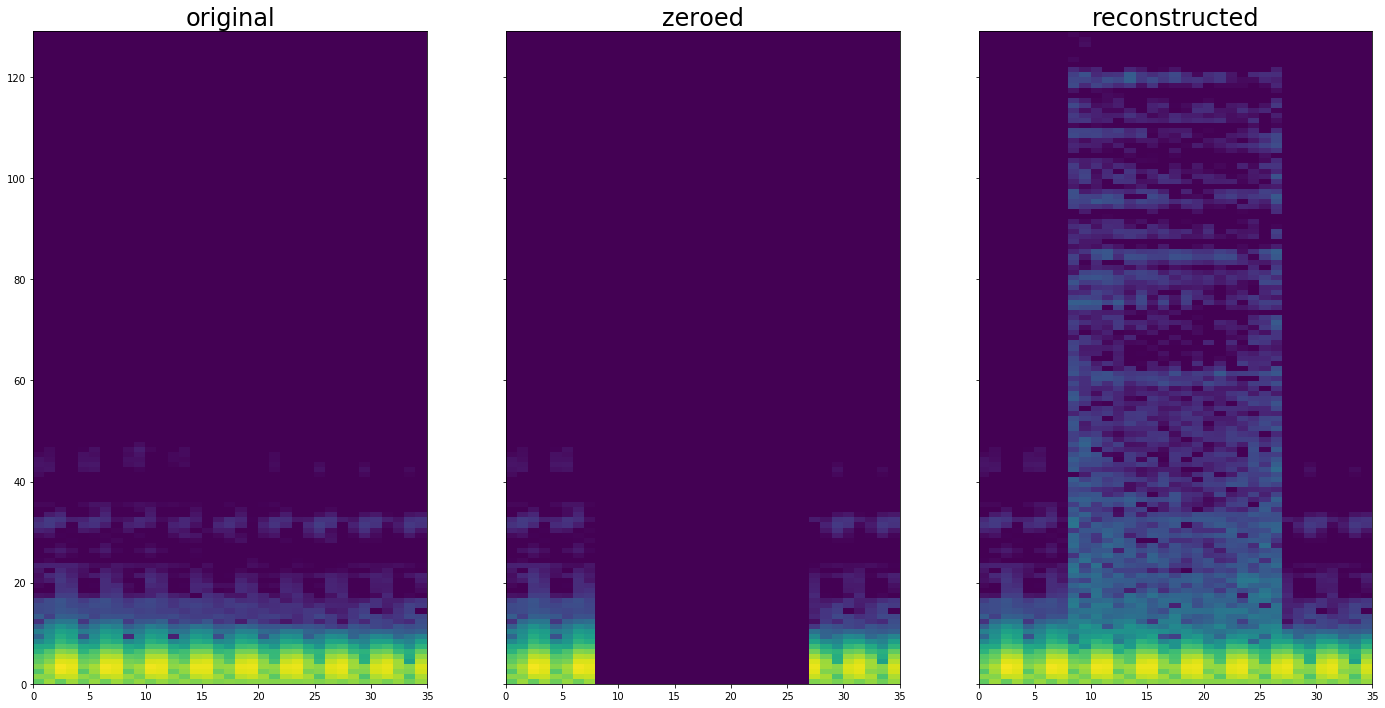

In [122]:
testOn = 17
import pylab
pylab.rcParams['figure.figsize'] = (14, 8)
f, axarr = plt.subplots(1, 3, sharey='row', figsize=(24, 12))

#scaleeee
z_max = np.max(np.log10(np.abs(complexContext[testOn])))
z_min = z_max - 4

originalPlot = np.concatenate([complexContext[testOn, int(params.contextStftFrameCount())-8:int(params.contextStftFrameCount())], 
                         complexOriginal[testOn],
                         complexContext[testOn, int(params.contextStftFrameCount()):int(params.contextStftFrameCount())+8]], 
                        axis=0)
zeroedPlot = np.concatenate([complexContext[testOn, int(params.contextStftFrameCount())-8:int(params.contextStftFrameCount())], 
                         np.zeros(complexOriginal[0].shape)+1e-10,
                         complexContext[testOn, int(params.contextStftFrameCount()):int(params.contextStftFrameCount())+8]], 
                        axis=0)
reconstructedPlot = np.concatenate([complexContext[testOn, int(params.contextStftFrameCount())-8:int(params.contextStftFrameCount())], 
                         complexGenerated[testOn],
                         complexContext[testOn, int(params.contextStftFrameCount()):int(params.contextStftFrameCount())+8]], 
                        axis=0)

axarr[0].pcolormesh(np.log10(np.abs(originalPlot)).transpose(), vmin=z_min, vmax=z_max)
axarr[0].set_title('original', size=24)
axarr[1].pcolormesh(np.log10(np.abs(zeroedPlot)).transpose(), vmin=z_min, vmax=z_max)
axarr[1].set_title('zeroed', size=24)
axarr[2].pcolormesh(np.log10(np.abs(reconstructedPlot)).transpose(), vmin=z_min, vmax=z_max)
axarr[2].set_title('reconstructed', size=24);

plt.savefig('test.png')

print(_pavlovs_SNR(generatedTimeSignals[testOn], originalTimeSignals[testOn], onAxis=(0)))

In [100]:
np.mean(np.abs(complexContextdata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABWkAAALECAYAAAB6yLJhAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAIABJREFUeJzs3XmYnNldH/rv6S611pFa0mik2Twztsf7AhhsBwiYmMUQLuYaAnYSYme5TgIJJLkhhEBik+uwhC1PSMjFBBggBAgOBJJAiCGxDUkMOL7GeJ/x7KOZkUbbaO1WdZ37R1WjdrtbOq9arbdn9Pk8Tz09XfV9T52u1ujU+9Op91dqrQEAAAAAoB9TfU8AAAAAAOBapkgLAAAAANAjRVoAAAAAgB4p0gIAAAAA9EiRFgAAAACgR4q0AAAAAAA9UqSFK6SUcnsppZZS6hUe91WTce+/kuOuRSnlXZM5vanvuQDAU1kp5U2TNfVdfc8FALj6nF+zaND3BAAAAAB46imlvCrJq5J8oNb6H/qdTXeTwujtSf5DrfUD/c6Ga52dtHDlnE/y8cntSjozGfOTV3hcAAAAWItXJXlLkq/ueR6X600Zz/8zep4H2EkLV0qt9ZEkz1uHcX9/PcYFAAAAYGOwkxYAAAAAoEeKtFyTSimvK6X8l1LK4VLKXCnl4VLKz5VSPmuF7Kc0BCulvLKU8o5SyqOllIVSyj9bKbfK835lKeW/l1JOlFKeLKW8t5TyxsljK14s/GKNw5YeU0rZWkp5aynl46WUs6WUQ6WUXyil3LnKXGZKKX+6lPLjpZQ/LKU8UUo5V0p5YPJavKzLawoAyaesTZe6vXWFY2dKKX+jlPI7pZSjkzX6gVLKT5ZSnr/K8921OF4pZXMp5TtKKR8spZyc3D+7LP9FpZRfLqU8VkqZn3z9lVLKn2r42T5/srY+PJnbkVLKb5VS3lBKKRc57qZSyttLKY9M1tp7Syk/tHxuAPSjlHL/ZM14VSnl5lLKj07+rp4rpXxgWfZy14JSSvn6Usp/nqw9c5N14T2llL9dStm7wjFTpZS/XEp592RdPFdKuW+ypjx7lef5lPPHUsrnlVL+0+R87+zk3O9vrDbXUsoNpZTvL6V8qJRyevKcD5VS/mcp5R+XUm6b5G4v43Pft0wOfeMKa/3tS7Pl0ufUl2ymOVnvaynlrotkvmwy/uLv6LEyPvf+zlLKrUufK8kXTg77qWVzv3+FcTu/T1ly7GtKKf+tfGot4BsudgzXHpc74JpSSplK8lNJ/sLkroUkJ5PcnOTPJnl9KeVv1Fr/1SrHf12Sn8v4/50Tk+Nbn/s7k/w/k2/r5PjPSfKKUspar3+zM8n/SPKZSeaSjJLsS/L1Sb6klPLyWuvya9p+aZL/uOT7M5N5PSPj1+LrSil/qdb6s2ucGwDXlqNJHr/I4/tXurOUcmOS30jy0sldoySnM16X/mKSN5RS/lyt9ZdXGXdLkvckeXnG14k/s8JzvC3Jd0y+XVyLb8j4OnpfXUr53lrrt68yv+9L8veW3HUyyWySV09uXzWZ32jZcc9P8u6M1+VMfqYDSf52kv8jyYrvOQDoxXOS/FKS6zNeR84vfXANa8GuJO9I8sWTuxbXoANJbkryJ5McS3LXkmO2JfmVjM/bkgtr2+1J/q8k31BKeX2t9VdX+2HKeAPQv854g96TGa+VL0nyI0meneRvLcvfluR/JblxctfC5Libk9yS5E8kOZjk/5089niSHUm2Jzk3+ZmW+rTz5bWcU19KKWUmyU8k+fNL7j6RZG/G7z9eMXnetyY5O5n/niSbMv45zy457vCysS/7fUop5VuT/NPJt0trAT9zBWoBPI3YScu15u9lXKCtSf5hkt211t0ZLzi/lPH/E/+ilPIFqxz/E0l+NckdtdbZJNuS/LNLPWkp5YtyoUD7U0kOTJ53T5K3Zbw4ruUv5+9KsjvJazJeIHck+YIkD0+e43tWOObUZC6vTnJ9rXV7rXVrktsmP9MgydtLKc9Yw7wAuMbUWl9Xaz2w0i0XdtsMk/z24jGllE0Zr68vzbjQ+gVJttZad2Z8AvuDGZ9Y/mwp5VmrPPU3ZXxy/fokOybr9O0Zn0CllPL6XCjQ/oskN0zW4n0Zn6wmyd8vpSw9sVuc37dk/B7icJJvzPj9w86M19yvS/Lo5Hm/bdlxmzI+Kd+X5N4kX1hr3ZHxOv1VSXYl+UervZYAXHU/mPHf6Z83OT/akeRrk8tfCyZ+LuMC7dkk35Jkz2QN2prkxUn+ccZF2qV+KOMC7VySv5bkusna9twk78p4Xfy3pZTnrPKz7EvyYxn/Y+CNk2N358Ka982llBcuO+YtGRdo78l4LZ6pte5ZMs+3JXksSWqtD03W9h+YHPuLK6z9D60wr8s6p270wxkXaBcyPkc+MHmOrRm/R/jWjIvMqbX+4mT+/3Ny7Lcsm/vnLA66lvcppZTPT/J9k2//TZKbJr/7vRkXbv9ONC1jUa3Vze2auGW8eJ7IuED7PSs8Pp3kdyaPv2fJ/bdP7qtJfjfJ1Crj/3FuhcfePXnsN5OUFR7/0SXP8aZlj71qcv/9Kxz3rsljZ5I8e4XHv2by+LmMF9gur9dPTI59y0We901dxnRzc3Nzu3ZvGe8Smp+sH3992WN/ZXL/7yfZvMrxi2vlv1h2/11L1tAvXeXYkuTuSebnV8n828X1dulan/EOqZMZ72B6+SrHvjLjHTVHl663Sb5hMuZckueu8poszv1dff+O3Nzc3K7V2+Tv/ppxoXT/Co+vZS34isnYoySvaZzPbRkXGmuSv7rC49syLqTWJD+z7LHF88ea5MdXGf+Dk8f/0bL7PzK5/+s7vHZvnRxz10Uyt6ftnPpNl1oTV3u+JC+cvMY1yZs7zP+S57ZrfJ/y25P7/1tWrgX86yWvzapzcLs2bnbSci350owvCzCfCx81+GO11oVc2O36J0spB1YY4wfrso+uXEop5fqM/6UtSf5prXWla9Z+3wr3dfGOWus9K9z/axn/Zb8544+zdLF4KYTPW8vEAGDyqYx/n/HHCX+sfvplhd44+fova61zqwzzbydfv2SVxz9Ya/2vqzz2GbmwDr5tlcx3Tb7elvElExZ9TcY7X3+31vr7Kx1Ya31vxjtldydZek33r518/eVa68dXOO53Mt6RA8DG8DO11pUu2bOWtWDxUnu/WWv9L43zeF3Gn/J8LOMi3vLnOpML57SvK6VMrzLOSp+oTMa7QpPkRcvuf3Ly9casn87n1I2+IeN/lP1YrfXtV3jsy3qfUkrZk+SLJt9+3yq1gO++MlPk6cA1abmWLDYF+8Na6/KPkix6T8YfwRxM8r++7PH/dRnPu/jRhVEufJTiU9RaHyilPJjx9Wwuxx+sMu75UsqhjK+/s3v545NF45uSfHnGH5vZlfGO4qVuusw5AcDiNfX+Q8Yfu/ydJH9z2eODXCiK/tDken8rWVyfbl3l8Yut0YvvAQ7XWj+8UqDW+vFSyiMZX3fvs5K8d/LQ506+vqKU8thFnmPPkvktzmXxed99kePenQv/mAtAv1ZbS9ayFrxy8nX5ueXFLK4fvzPZTLSS/zb5uj3jc7mPLHv8aK313lWOfWTydfk54q9nfN3W7yvjBtTvSPLeWuvZXDmXc07d4nJe50ta4/uUz8y4cDzKeAfxp6m13ltKeSirv7/hGqJIy7VksWHHI6sFaq3nSilHMi5q7lshcniF+y7l+snXE5dY3A7m8ou0Jy/y2LnJ101L7yylvCDjhX1pA5eTGV8nqSaZyXjR3n6ZcwKAJPnJjE9SHkjyNbXW88se35PxmrP435eydZX7L7ZGX/I9wMTDGRdpl74HWNxNtPUiz73UthWe9+BF8peaEwBXz2pryVrWgsXzrQc7zKNl3Xp4hfxSnc8RM/6E58syvm76N05uw1LKH2TcxOzHa63HLzJui8s5p25xOa9zi7W8T1n8vZyotZ6+yDGPRJGWaBzGtWnz5R54kX/FvJhyuc+3zn4q44Xs/Rk3HLuu1rqz1rq/ji+g/mcmuY06fwA2uFLKP0jy9RlfO/21tdaVTsyWvh99aa21XOq2ytO1rNGX8x5gcX4/3DK3WutdHce3zgJsHKutJeu9FqzmYuvWSh+dX5Na61yt9bVJ/kTGl1N47+R5Fr//RCnlpWt8jss5p26xXuvplXqfcjHeC5BEkZZry+KJ4W2rBUopWzLusrg0f6Wed1cp5WL/6rqe1/35FJNrA7484zchX1Vr/c1a66llsf2ffiQAtCmlfGXG13qvSd5Ya/3DVaJHcuGk+AXrNJ3FtfhSn1i5ZVk+SRavTXg5c1sc52KXDrpq6z8Al20ta8Hisaueh67gkueu+dSdl1d0d2qt9b211m+rtf6JjD9d+YaMd6juywrXyL2ChpOvWy6S2bXK/YuXoejyOrdYy/uUpbWAbRfJeS9AEkVari3vn3y9s5Ry8yqZL8iFy4C8f5VMVx+YfJ3KhWsZfYpJ0fRKLyYX88cnobXW1T5C88VXazIAPL2UUp6X5OcyXvveVmt9x2rZyeUP3jf59nXrNKXFNX17KeXlKwVKKc/J+FIHS/PJhWvnfWEpZW+6WRznYtec/cKOYwJw9a1lLVi8xvlXdDhmcf14xUWKe39q8vV0kk9rTnml1FpP11p/IcmbJ3e9rJSy9JJ4i03ArsRu0MVLKdxykcznrHL/4uv85R2f86LzX+P7lP8v43+snkry+SsFSil35PIve8jTjCIt15L/mnG3yk1JvnX5g5OOmP9w8u3v1FovdkH4ZrXWJzJulJIkf3eV2KfNZ52dmHzdX0q5YfmDpZQXJ/mzV3dKADwdlFJmk/xakp0ZNwx7S8Nhd02+fk0p5YsuFiylfFojzAYfSHLP5L//wSqZt06+3p9kaefuX8r4BHhLku/vOLdfmnx93aQBy/L850bTMICngrWsBT8z+fqlpZTXND7fL2dcPNybC8XRpc+xLRfOIX/5Sl1CoJQyc5GHF/urlFy4RmsyPsdOktkrMIU/mny9uZTysuUPllL+ZJLPW+XYn824IPq8Uspf7fCcLfO/a/K10/uUWuvRXGjw9vdKKSsVgv9+4zy5BijScs2YXKj7uyfffnMp5TtKKTuSZLKz9ucz/tetUZLvvMJP/48nX19TSvnXi4XRUsrOUsp3JfmmXCicXg0fzfhC8yXJL5ZSnj2Zz6ZSyuuSvDPJ8ssfAECLX0hyZ5IPJfmGWmvLNfN+IuMdMFNJ/lMp5VtKKX/cnKOUckMp5Q2llHcl+ZauE5rMYXFtf20p5UcWd0KVUvaWUv55xh/lTJLvrLWOlhx7JMm3T779i6WUf1dKedGSuW0ppXx+KeVfJvkfy576FzPutr05ya+XUj5/csxUKeVPZ3wS/mQA2NDWuBb8xuRWkvz7UsrfnPyDZkopM6WUF5dSfrCU8tVLnu+BJG+ffPu9pZQ3l1I2T455TpL/nOTZGV/z/W1X8Ef9UCnlu0spn7NYsC1jL0/yI5PMH9Rajy055sOTr5+/0j9IdjH5uRf/ofSuyeahxfPUP5PxP/4eW+XYDyf5scm3/7KU8tYl593TpZQ7J/f9tWWHLs7/daWU1S6lsJb3KW/NuHj86snPtH9yzK5SyndnXIT3XoCxWqub2zVzSzKd5Kcz/kuyZnzNm6MZF2Zrxtea+cZlx9y+mL/E2BfNZbyTaPF5R5PnHU6+//4k75789xuWHfeqyf33rzDmuyaPveki87p/knnVsvv/z8nPuzinJ5PMTf77gSR/fi3P6+bm5uZ2bd6WrSuPXeT2d5cdd0OS311hrTy55L6a5C3Ljrtrcv9bG+b2tiXjLEzGX7oWfs9Fjv3OJe8XasY7qpYff98Kx70gyaElmZMZn1TXJHcn+TuT/35X3787Nzc3t2v1tto50wq5y10LZpecQ622Br1p2THbMv406OLj8xkXKBe/P5dxU87lz/Wq1c7jlmTetNLak/HlBpaeKx+ZPO/ifYeTvGTZMZsy/rTK4tp9aPJ63p/klknm9sUxGn4Xr1iyTi6um4vnqb+5ZC2/a4VjN2f8D6RL3zccS3J+yfdvXXbM85aMfz7JI5O5/+6y3GW9T5kc+60rHLdYC/jBOL92m9zspOWaUmtdqLW+McnXZrzgHU+yI8mjGe+kfXmt9UfX6bm/K8lrk7wn48V8kOQPMt5l9K25cAH04yuPcMXn8ysZX8fonRkvLJsyLs7+QJLPzHinLQBcrusybkK52m3H0nCt9VDG12f9c0l+PeOTvB0Z7zz6WMa7WL4iFz4V01mt9Tsz3snyq0memIx/JOPLM3xxrfXbL3Ls25K8NOOdTXdP5rU94/cQv5Hkr2d8Yrn8uI8k+YyMG608mvF6+1iSH874unpHL/fnAeDqWsNacDzjc683JvmtjP/uXzwPfXeSv5XxWrT0mDMZX1/1r2R8+bwzGRduH8h4TXlxrfVXr/CP+Nok35PxbuCDkznOJ/lgku9N8sJa6weXzfN8xmvrz2Zc4Nydcb+V23Kh30uzWuvvZfwJ1/+Y8bnxIMknMi50fkUuNBdb6di5WuvXT36O/5hx07btGa/5703yHUl+fNkxH0vyJUn+S8afbj0wmfsty3KX/T6l1vr9Gf8u/3vGn1gdZHyd279Qa/2/W14Xrg2l1pZPoAHraXLh9SMZ/8vfHbXW+/udEQAAAABXi520sDF8c8YF2rsVaAEAAACuLZ23ngOXp5TyQxl/TOQ3aq2PT+47kOQbc6HT9A/2ND0AAAAAeuJyB3CVlFJ+N8nnTb49N7nNLon8bJI3Vv9TAgAAAFxTFGnhKimlfHmSr8v4QvIHMr7I+LGMLxj+k7XWf9/j9AAAAADoyYYo0s6UzXVLtvc9DQA2qJM59kStdV/f83gqssYCcDHW2MtnjV1/pZTm7EaobQAsupz1dUNck3ZLtucV5dV9TwOADeq36jse6HsOT1XWWAAuxhp7+ayx629qZqY5O5qfX8eZAHRzOevr1HpMBAAAAACANoq0AAAAAAA9UqQFAAAAAOiRIi0AAAAAQI82ROMwAAAAgKW6NAOb2rq129hnz3adDsC6spMWAAAAAKBHirQAAAAAAD1SpAUAAAAA6JEiLQAAAABAjzQOAwAAAJ7SykB5A3hqs5MWAAAAAKBHirQAAAAAAD1SpAUAAAAA6JEiLQAAAABAj1xZGwAAAHhKWzh5su8pAKyJnbQAAAAAAD1SpAUAAAAA6JEiLQAAAABAjxRpAQAAAAB6pEgLAAAAANAjRVoAAAAAgB4p0gIAAAAA9EiRFgAAAACgR4q0AAAAAAA9GvQ9AQAAAIDlpjZvac6O5s6t40wA1p+dtAAAAAAAPVKkBQAAAADokSItAAAAAECPFGkBAAAAAHqkcRgAAACw4WgGBlxL7KQFAAAAAOiRIi0AAAAAQI8UaQEAAAAAeqRICwAAAADQI43DAAAAgA1n8Nxnt4ePHu82+HU7mqPDe+/vNnajwbOf2e2AJ082R4eHDjdny/R0c3Z6drY5myTDI0c65bk8g2fc0pwdPvjwOs6EtbCTFgAAAACgR4q0AAAAAAA9UqQFAAAAAOiRIi0AAAAAQI80DgMAAAA2nPn91zVn556/t9PY133saHN26jNf0D7wVPteuKPPa//5kmTnve356f3tr8fCjs3N2TOzM83ZJNl2357m7Oi+h5qz5c7b2sfd0m3O0w882pwdHn6iOTt43p3N2bqpvZlbktRaO+XZmOykBQAAAADo0SWLtKWUnyylHCqlfGjJfd9fSvlYKeWDpZRfKaXMLnns20sp95RSPl5K+bL1mjgAAAAAwNNBy07au5K8Ztl970zyolrrS5J8Ism3J0kp5QVJXp/khZNjfrSU0m2PNgAAAADANeSSRdpa63uSHF1233+ttQ4n3743yS2T/35tkl+otc7VWu9Lck+Sl1/B+QIAAAAAPK1cicZhfynJL07+++aMi7aLHp7c92lKKW9O8uYk2ZJtV2AaAEBijQWA9WKNvbpGm9s/mDtzcnjp0BLD2fbf39z17Y21pudGzdnatUtQh95QZ29ubzK2+ei55mxZ6NagarR5U3v4hc9qn8eZ+U7z6GTU/jNObd3aPuyDj7SPe9OB5mySZH4dXw+umjU1DiulfEeSYZKfW7xrhdiKf7prrW+vtX52rfWzN6X9LzwA4OKssQCwPqyxAKyXy95JW0p5Y5KvTPLqWutiIfbhJLcuid2S5ODlTw8AAAAA4OntsnbSllJek+TbknxVrfXMkod+LcnrSymbSyl3JLkzye+vfZoAAAAAAE9Pl9xJW0r5+SSvSnJ9KeXhJG9J8u1JNid5ZyklSd5ba/1rtdYPl1L+XZKPZHwZhG+qtS6s1+QBAAAAAJ7qLlmkrbW+YYW7f+Ii+X+S5J+sZVIAAAAAANeKy74mLQAAAMB6GQ1W6k2+sm33neg09tzNO5uzWw6fa85OnzjbnN10bEtzNkmm7nmoObvlmTe3D/yhu9vHnZlpH7ejcv3e5uzw/geas1Md5zzqlO4w7vx8e/ihbu2dpm69qeNs2Igu65q0AAAAAABcGYq0AAAAAAA9UqQFAAAAAOiRIi0AAAAAQI80DgMAAAA2nK2/d09zdnj0WKexNz24rT08HLZHuzSH6mihS/j9x9dnEuv48+XUqXUZtlPDrg1iNNferC5JymOH1mkmXE120gIAAAAA9EiRFgAAAACgR4q0AAAAAAA9UqQFAAAAAOiRxmEAAADAhrPQsRlYF6MzZ5qzU9vam4x12Qn3VGxoxca0sE5N17i67KQFAAAAAOiRIi0AAAAAQI8UaQEAAAAAeqRICwAAAADQI43DAAAAgA1n6qUvaM8+cbzT2AuPPd4errV9Htfvbc6ODj7aPoeOpmdn28PDYXN0ozSompqZac5eCw3aBs99dnN2+PF71nEmrIWdtAAAAAAAPVKkBQAAAADokSItAAAAAECPFGkBAAAAAHqkcRgAAACw4cwd2N6c3Tzotgdt6smT7eFNHUonUxtjL1yZ3dUe3rypPfuJezvNY2rrlvbsjfubs3Vre+OwfOjj7dkkgxv2tYc3tb92w0cONmc7NX5LsjC7rVOejWlj/O0BAAAAAHCNUqQFAAAAAOiRIi0AAAAAQI8UaQEAAAAAeqRxGAAAALDhbHnkyfbwQ491Grvs3dOcHT36eHO2nj7bnB3cfFNzNunWeCqjheZoffxE+7h11J5NUufPt2e3be4wcG2ODvbubR83SR0O28P728cedJhztndsBPa/P9otz4ZkJy0AAAAAQI8UaQEAAAAAeqRICwAAAADQI0VaAAAAAIAeaRwGAAAAbDgL121pzk7ftL/b4GfnmqNT17c3GUspzdHRvl3t4yYZbNrUPnaHZmdl+9b2OTzvzuZskuTUmfbssZPN0XrqdPu4m2fas0lyZr45Wg4ebs7W+fZxFw4+2pxNksEzbmnODh98uNPYXD120gIAAAAA9EiRFgAAAACgR4q0AAAAAAA9UqQFAAAAAOiRxmEAAADAhjM1v9CcHV23udPY0yc7NJ7q0LBreP8DzdnOBZmZ9nlM7b++fdxh++tcB932+pUOc86m9lekbG1vKldnptvnkCQPnm0fe669AV3uaG/ulT/6WHs2ST12olOejclOWgAAAACAHinSAgAAAAD0SJEWAAAAAKBHirQAAAAAAD3SOAwAAADYeP7oE83ROj/faejRzEx79vyw09ithg8/si7jrquDj/Y9g6es6fseXrexR2fPrdvYXD120gIAAAAA9EiRFgAAAACgR4q0AAAAAAA9UqQFAAAAAOiRxmEAAADAhjP/BS9pzpZaO429MGrPDk63NyVb2NJeZpl5/GT7JJKMdmxpztYPfLQ5O713T/skpqfbsx0NH32sOVs6zKMuLFzOdJpMz842Z8u+ve0D332q0zym7ryjObvw0faGfFxddtICAAAAAPRIkRYAAAAAoEeKtAAAAAAAPVKkBQAAAADokcZhAAAAwIYzGpTm7PRct8ZhnbaslQ7zODdsztZBt31zo5kOTbu6NMvq0EWtnjnbPm6Ssn9fc3ZqZqY5O5pvb+bW1WD/De3hTZuao7XL7++VL23PJpm7rn0eg/aeclxldtICAAAAAPRIkRYAAAAAoEeKtAAAAAAAPVKkBQAAAADokcZhAAAAwIaz7UMHm7P1+IlOY5fZXe3hqfbGYaMnjjZna4eGXUky2HVde/iG9oZdow6vXdm6tX0OSYafvK9TvtX0nt3N2bJtW6ex68lTzdmFxw81Zwfz7b+T6Q7N6pJk2KFxGBuXnbQAAAAAAD1SpAUAAAAA6JEiLQAAAABAjxRpAQAAAAB6pHEYAAAAsPFs2dwcLXtmu43doWnX6PEjzdmp6/c0Z4ePtDdGS5LRoXPN2eld7Y3RRvPz7ZPokk1Spqebs9MH9jdnR8eOt89hU7emWqXD73D6pg5znmkvwQ1ntzRnx2Pbg/l04LcIAAAAANAjRVoAAAAAgB4p0gIAAAAA9EiRFgAAAACgRxqHAQAAABtPhyZVw4e6NeGa3nldc7YOz7fPo0MzsMGNB5qzSTJ89LHm7MKJE53GbjW4YV+n/PDQ4fZsx0ZqzTo0iUuSqeFCc7aeOdM+7g3XN2dnznVr0DbY0d5orNurwdVkJy0AAAAAQI8UaQEAAAAAeqRICwAAAADQI0VaAAAAAIAeaRwGAAAAbDjDBx9et7HXq7FWF6MjR9dv8NJhT15tbyW1cPT4ZUymX6O5c+uabx73gYeas9O7dnUbewP8eWbt7KQFAAAAAOiRIi0AAAAAQI8UaQEAAAAAeqRICwAAAADQI43DAAAAgA1n8Kw72sPn5roNvmVze/bM2ebo6Hh7A6fR2fZxk6QMNrWHOzQDqwsdhh2ebw9z2er8fKf89POf05xd+Ognuk6Hq8ROWgAAAACAHinSAgAAAAD0SJEWAAAAAKBHirQAAAAAAD3SOAwAAADYcIb7dzVnB/c/3mnsuq29cVg5/mRzduq2W9qzZ881Z5Nk+MBDnfLrYXp2tlN+4fjx5uzghn3N2eGhw83ZqZmZ5mySjDo07Rrcflv7uI92+DP6gme1Z5PUTmk2KjtpAQCgOLAsAAAgAElEQVQAAAB6pEgLAAAAANAjRVoAAAAAgB4p0gIAAAAA9EiRFgAAAACgR4O+JwAAAACw3NTcsDk7/5wbO409+L2Ptodvv7U5uvDRTzRny2e/uH0OSQbn5trD27c1R4f33t+cLTu2t88hyfSw/XdY5+abs1MzM83Z0Xz7uF0N73+gOTu48UBztn6ifdwkKQduaM6OOo3M1WQnLQAAAABAjxRpAQAAAAB6pEgLAAAAANAjRVoAAAAAgB5pHAYAAABsOOX8QnO2TpduY3doPNVpe9srX9o+7OkOjcCSDB8/1JwdPOOW9nm87EXtkzh8vD2bZOHUqebs4Lb2Bm1l7+7m7NTpM83ZJBkeeqJ97C2b2wcetbfsKjuvax83yckXXd+c3Xr3JzuNzdVzyb9qSik/WUo5VEr50JL79pRS3llKuXvydffk/lJK+eellHtKKR8spXzWek4eAAAAAOCpruXfg+5K8ppl9/39JL9da70zyW9Pvk+SL09y5+T25iT/6spMEwAAAADg6emSRdpa63uSHF1292uT/PTkv386yVcvuf9n6th7k8yWUm68UpMFAAAAAHi6udzGYftrrY8myeTrDZP7b07y0JLcw5P7Pk0p5c2llPeVUt53Pt2uwwIArM4aCwDrwxoLwHq50o3DVrpSd10pWGt9e5K3J8nOsmfFDADQnTUWANaHNfbqKifam05Nb+vQCCxJ2dyeH374E83Zqc96YXO2Drrtm5vetat97FOnm7Nltr1JVd21ozmbJIOb2j9cPXzwkfZxn7HifsCVdfhddx174ZHH2gfu0Dhs+MjB9nGTbL93tn0anUbmarrcnbSPL17GYPJ1scXgw0mWtuO7JUm3P1kAAAAAANeQyy3S/lqSN07++41JfnXJ/X+hjL0yyYnFyyIAAAAAAPDpLnm5g1LKzyd5VZLrSykPJ3lLku9N8u9KKX85yYNJ/swk/utJviLJPUnOJPmL6zBnAAAAAICnjUsWaWutb1jloVevkK1JvmmtkwIAAAAAuFZc6cZhAAAAAGt3bq45OvX+j3Yb+7r2ZlldjN7/4ebs1LZtncYus+2Nw4YHO1x58uixTvPYCIYPPNT3FDobHn6iOTu4YV+3wQ+3/w41Dtu4LveatAAAAAAAXAGKtAAAAAAAPVKkBQAAAADokSItAAAAAECPNA4DAAAANpxTr7i9ObvjfR0bSW3d0hyduu1Ac7acX2jPnjvfnE2S8/vbm52V225ozg4eOdKcHT74cHM2SQbPvL197Hvvbx937972Sezb055NMto205wtcx1+hx06ds3fsKM9nGTqfIfBuzSV46qykxYAAAAAoEeKtAAAAAAAPVKkBQAAAADokSItAAAAAECPNA4DAAAANpxS27Nzz7+p29gL7YPP79rUnB2cbm8cNvit9zVnk6Tc077Pbv7LXtacrdPXt8+hY+Ow0cMHm7NTW7c2Z4dH2pudlTu6/dkYbW0vlQ06NIob7ejQkGyhQyOwJKdubW+E160lGVeTnbQAAAAAAD1SpAUAAAAA6JEiLQAAAABAjxRpAQAAAAB6pHEYAAAAsOEMzrQ3ZUq3Pks5u6+9idP0XPvgC1va98LNfNYLm7NJMr+nvbHW4MywOVs6vHaD593ZHk6ysKO9odXU6bn2eRw51j6Jw8fbs0mmB+2lsuEn72sf9/nPac+eOducTZLBnhs75dmY7KQFAAAAAOiRIi0AAAAAQI8UaQEAAAAAeqRICwAAAADQI43DAAAAgA2nDGtzdnCyvelUkmw63t6YqZxrb8I13LutOTt1Zr45myQzC+2vR6kdssdPNmdHjx1qzibJ9K03N2frzKb2eRw/0T6Jk6fas0lGZ9v/bAyedUf7wGfb/4zWjnPe9kB7vmOPPa4iO2kBAAAAAHqkSAsAAAAA0CNFWgAAAACAHinSAgAAAAD0SOMwAAAAYMOZevf727M33dhp7OHBR7tOp0npMod1mcHY4IZ97fM4dHjd5jH65H3N2enZ2fZx57s1XVsvC/c/2JytCwvrNo/pG9t/32xcdtICAAAAAPRIkRYAAAAAoEeKtAAAAAAAPVKkBQAAAADokcZhAAAAwFPaejUCS5IyPd2cXc/mUF2sZzOw9bJw/HjfU+hso/y+Fz78ib6nwBVgJy0AAAAAQI8UaQEAAAAAeqRICwAAAADQI0VaAAAAAIAeaRwGAAAAbDiDm25szo6OHOs09tSe2fbwzh3t2VKao6N7H2gfN0nZtq0526UJ1/SuXe3jnjjRnE2emk3XupjavKU9u3d3c3Y9G+GxcdlJCwAAAADQI0VaAAAAAIAeKdICAAAAAPRIkRYAAAAAoEcahwEAAAAbTt19XXt4f3tTpiSp9x1sD+/Z2RwtC7U5O3Vdh58vyfDIkebs9POf05wtx59sn0THxmFdmoFN72hv0FZuuL45O7z3/uZsV6O5c83Zcubsus2jDDY1Z+vw/LrNg7WxkxYAAAAAoEeKtAAAAAAAPVKkBQAAAADokSItAAAAAECPNA4DAAAANpxytL2h1ejWfZ3GnjrQId+hGdhwdltztuzc0j6HJOVZN7Vnn2xvaLVwc/trMdi2tTmbJHWmvaFVDj7ePu62ze3jlm77EwcHbmifx9xc+zQ6zqOLhc97cXN26t3vX7d5sDZ20gIAAAAA9EiRFgAAAACgR4q0AAAAAAA9UqQFAAAAAOiRxmEAAADAhlNndzZnp4+e7jb4+fPt2eFC+zwG7XvhRttm2ueQZOrMfHv4yLH2caf3tI9bSns2SR4/3D70oEOJ6sn23/f0ju3t4yZZOHykfezdu9oH7tJ07Uj7HJJkaq79zygbl520AAAAAAA9UqQFAAAAAOiRIi0AAAAAQI8UaQEAAAAAeqRxGAAAALDxbJpuzx49vm7TGD5+qD38yLpNI+vWGurwE+s18vrp1ldr3Qw3ymv33j/sewZcAXbSAgAAAAD0SJEWAAAAAKBHirQAAAAAAD1SpAUAAAAA6JHGYQAAAMDG88DB9uzmmU5D17n55uzgmbe3D3ziZHN0eKRb96upbduas6MzZ5qzg5tubM4ODz7anO1qavOW9uzOHc3Z9Wzu1WXOo7lz7eNu3dptHnv3NGeHD69jdzvWxE5aAAAAAIAeKdICAAAAAPRIkRYAAAAAoEeKtAAAAAAAPdI4DAAAANhwyvXtzZBGs9s7jX361vb8aFNpzu54cGdztr7gGc3ZJKlzw/bwVPuevPOD9p9v4QU3t88hyfTcQnv4dHszt1Gt7dmOr/P0ufbXuXz43vZxn/2c5uyZO2abs0kyNzvdnN35bzQO26jspAUAAAAA6JEiLQAAAABAjxRpAQAAAAB6pEgLAAAAANAjjcMAAACADWf+1t3N2ZmPPNRp7MHe29rnsbO9dDJ16lxz9twzuzWHKqNNzdnBqQ5Nxjo04Rpub29QlSQLW9r3Bnboz5bSPuWcv65b6Wu4rf1n3Hbj/ubswsc+2Zyd2f3i5mySnN++pVOejclOWgAAAACAHinSAgAAAAD0SJEWAAAAAKBHirQAAAAAAD1SpAUAAAAA6FG3FncAAAAAV8HU3EJzdnj4SKextz6wqzm76eP3NGfbZ5xs2friDul02mY3feRUe/jcXHN0sH93+7hJynDUnj073z7w+WFzdPrU9vZxk6SU9ux0+y9lev8N7dm7D7bPIcmuY7PN2S5/Rrm67KQFAAAAAOiRIi0AAAAAQI8UaQEAAAAAeqRICwAAAADQI43DAAAAgA1n8ODh5uxoy+Zugw/b2ycNnnFL+7gL7Y2y6sfuax83STnQ3niqPnG0Obtw4kRzdvr0meZsktS59qZkC2fPdhq71fSx9iZxSbfXo/23nQzufFZzdnj3JzuMnOSOG7vl2ZDspAUAAAAA6JEiLQAAAABAjxRpAQAAAAB6pEgLAAAAANAjjcMAAACAjedce9Op85/7gk5DjwYd9qzV2hzdem97w67zz9rfPockdVP7nKcO7GzObrrvUPsc9nZrwjV1pv13ONWlKdn8+fbsbPtrkSSDHdvbw5tnmqOj67Y0Z6df9Nz2OSQ5O9s+j/YkV5udtAAAAAAAPVKkBQAAAADokSItAAAAAECPFGkBAAAAAHqkcRgAAACw4cy95Pbm7PzObuWNOlWas9Pzo/Z53DLbnB082d5UK0nO72pvPFWn2/fkDW/d15wdPNreGC1J6q4dzdnSoUFbvb79dS6HOs553+72sc/Ot2fPLzRnh7u3NWeTZOtDJ5qz7bPgalvTTtpSyt8upXy4lPKhUsrPl1K2lFLuKKX8Xinl7lLKL5ZSNI4DAAAAAFjFZRdpSyk3J/nmJJ9da31Rkukkr0/yfUl+uNZ6Z5JjSf7ylZgoAAAAAMDT0VqvSTtIsrWUMkiyLcmjSf5UkndMHv/pJF+9xucAAAAAAHjauuwiba31kSQ/kOTBjIuzJ5L87yTHa63DSezhJDevdHwp5c2llPeVUt53Pt2uwwIArM4aCwDrwxoLwHq57MZhpZTdSV6b5I4kx5P8UpIvXyG64pWfa61vT/L2JNlZ9rRfHRoAuChrLACsD2vs1TW3u71kse2xbkXzOt3eOOz8jvZ51NI+7tTJc83ZJNncIT/atrlDdlNztl7XraFVOdPh97LQ3qAtww7ZqW77E8vc8NKhidGjjzdn61z7azH84s9qzibJwpadzdnBhzsNzVW0lssdfHGS+2qth2ut55P8cpLPTTI7ufxBktyS5OAa5wgAAAAA8LS1liLtg0leWUrZVkopSV6d5CNJ/nuSr51k3pjkV9c2RQAAAACAp6+1XJP29zJuEPb+JH80GevtSb4tyd8ppdyTZG+Sn7gC8wQAAAAAeFq67GvSJkmt9S1J3rLs7nuTvHwt4wIAAAAAXCvWVKQFAAAAWA9bjpxvzg7ub2/glCSjfbubs9On55uzZb696VROn2nPJsm2rc3RqWNPtmdPzzRn69FjzdkkyaBD2Wl6uj37ZPvPN+w45+lduzrlW9WFhebs1rsPdxu8Q8O6Dn9CucrWck1aAAAAAADWSJEWAAAAAKBHirQAAAAAAD1SpAUAAAAA6JHGYQAAAMCGM3PwRHt4545OY5+/vr0J1/Tp9lZL0x0ah9UzZ5uzSbJw2w3N2cEjR5qzw3vu7TSPLsrLX9ycnTo515yt9z54OdNp06HB19Se9gZ0ozMdGsVNddtTObz+uvbwJzsNzVVkJy0AAAAAQI8UaQEAAAAAeqRICwAAAADQI0VaAAAAAIAeaRwGAAAAbDjzN+1qzo42dduDNjUcNWcHR041Z7vMeeZse9OpJDm/c6Y5O/WHR9uzL31Be/bgoeZsksxvaS87TR9rb6xVDuxrzo4eeKg5myRlb4ffy9Yt7dlXvrQ9+2j77y9JBvcebM62t7bjarOTFgAAAACgR4q0AAAAAAA9UqQFAAAAAOiRIi0AAAAAQI80DgMAAAA2nJPP2LxuY0+fr83Z0ab2RlLn9raXWTYd69B0qqOp2fYGZuf2bWvObn5oodM8yqj9dR7e/cnm7PSLntucHezd25xNkrpta3N24aOfaM5Ov+T5zdn5265vzibdXudy6HCnsbl67KQFAAAAAOiRIi0AAAAAQI8UaQEAAAAAeqRICwAAAADQI43DAAAAgA1n5tSoOTs93944KUlqac8O3vm+5uzWL3pZc3bhgx9tn0SSma0vac6Ojhxrzm55eEdzdni0fdwk2fRYe9O10eb2RmoLH/p4p3l0MRhMt2e7NCV78kz7uJva55AkU6fONWeHnUbmarKTFgAAAACgR4q0AAAAAAA9UqQFAAAAAOiRIi0AAAAAQI80DgMAAAA2nOv+8PH28MymboOfOduevfmm5ujg7seas3XXrvY5JBm978PN2XLdde3jPvBwc3Z6drY5myTDe+7tlN8Iho8fWpdxy/Hjzdl6/0Knsdtb7LGR2UkLAAAAANAjRVoAAAAAgB4p0gIAAAAA9EiRFgAAAACgRxqHAQAAABtO3TrTnC2HjnYbfOuW5ujCjXvb51Frc3b08CPN2a7KbHtTsjJqb1I1fLC9yVhXZdDe/K0Oz6/bPNbL9K23NGcXrt/Zaezzuzc3ZwfvfF+nsbl67KQFAAAAAOiRIi0AAAAAQI8UaQEAAAAAeqRICwAAAADQI43DAAAAgA1nuGd7c3Yw1W0PWjl9rjk7ffh4c3Z4457m7OBZdzRnkySltGdPnmrP7ujwOj+jvflVkmRuvjk6fPxQt7EbDZ55e7cDzs01R4cHH23O1u3tzb2m5ofN2SQ5t7f9d7ij08hcTXbSAgAAAAD0SJEWAAAAAKBHirQAAAAAAD1SpAUAAAAA6JHGYQAAAMCGU86P2sP3Pdxt8Ov3tmfPtjcZK7U2Z+uRY+1zSJJb9reP/cjJ5uzUoL00NHzkYHM2SQY33dg+j61bm7Ojs2fbJ3HqdHs2SWZmmqOD/Tc0Z0f3PNicrZ/xnOZskkyfa/9zx8ZlJy0AAAAAQI8UaQEAAAAAeqRICwAAAADQI0VaAAAAAIAeaRwGAAAAbDiDI6eas8NT7dkkmZ7Z1JwtO3c2Z+vvfbA5O5qebs4mSbm7vYHZ1M4dzdmuzcC6GB58tDk7tW3b+szh0OFO+cHe9qZywyNH2se9/bbmbP14e5OxJNk+vKU526EdH1eZnbQAAAAAAD1SpAUAAAAA6JEiLQAAAABAjxRpAQAAAAB6pHEYAAAAsOHUQ080Z8vLX9xp7PLYsfbwyfamZFObt7Rnb72pfQ5Jhvfc25wdHW5vMtbF9Oxsp/zC8ePN2dGZM12nsy66zGN6R3uDttGeDtkD3V7nqfMLnfJsTHbSAgAAAAD0SJEWAAAAAKBHirQAAAAAAD1SpAUAAAAA6JHGYQAAAMCGc/4zn9WcnT5zvtPYdef29uzj7Q3Mpvbubs6OHjrYnE2SqW3b2sfu0vxqT/ucF46daM4myfSuXe1jn2gfe/DsZzZnuzRcS5Kp225pH/tjd7cPvLm9BFfOj9rHTTL16JHmbLeRuZrspAUAAAAA6JEiLQAAAABAjxRpAQAAAAB6pEgLAAAAANAjjcMAAACADadOl+bs9EOHuw1e2scue2bbx92yuTk6mjvXPm5HU5u3NGcXjh5bt3l0aQaW0r6PsGszsC7qoQ6N4jq8zqP3/lFzdvqmA83ZJMn5bo3z2JjspAUAAAAA6JEiLQAAAABAjxRpAQAAAAB6pEgLAAAAANAjRVoAAAAAgB4N+p4AAAAAwHKDk/Pt4enpdZvH8JFHm7ODmw6s2zxS2vfZjebONWenZ2ebswvHjzdnk2Rq27b27NatzdnhkSOd5tFFPX22OTt14/727Hz7n+c6u6M5myTl3Pn28OEnOo3N1WMnLQAAAABAjxRpAQAAAAB6pEgLAAAAANAjRVoAAAAAgB5pHAYAAABsOOd3bW7OTj/Z3qAqSYYfu7vrdBonso574epofYY9c2Zdxk2SUYexy6ZN6zKHqZmZTvkuTdemNnUoqw3am9uV+YX2cZOMdrY3XWPjspMWAAAAAKBHirQAAAAAAD1SpAUAAAAA6JEiLQAAAABAjzQOAwAAADac0XRpzs7duLPT2JufvLE5W6+fbR/4yIlO8+iiTLc3npo+sL85O3zkYHN2cMO+5mySDA8dbg/f0j7nnGh/nadu7DBuktEDDzVnh/uua84Ojp5uztYOf/aTJB+5t1ueDclOWgAAAACAHinSAgAAAAD0SJEWAAAAAKBHirQAAAAAAD3SOAwAAADYeDo0T5o+O+w29nXbm6MLH/xoc3aw7/rm7PSLn9ecTZKFP/pYe7i0v3aDm9qbqI327W6fQ5J0aBxW73mwOTt41h3N2YXdO5qzSZIOjcPyPz/Qnn3us5uj5dS59nGTnP3ilzRnZ/7z73cam6vHTloAAAAAgB4p0gIAAAAA9EiRFgAAAACgR4q0AAAAAAA90jgMAAAA2HAWZtqbX9VBezZJzjz7/2fvTp81Oe/zvl93P9s5z9mX2VfsGADEYCNBipJih5VEcmyLiaWUU4lDp+RiUmW7nEqqEiV/QfImiV/kDctKiqnYiV2UHUlJWYqiWFYiS7QpguACEBxgMABm386+PFt3XmBEQTIoXb9zTk/3c/D9vAEHuOaeu/vpp3+n72nev0V/HhdetbMTd3t2NuuP7Kwk6XMX7egw0Dgs2+rb2Z0zsSZck3rGzo5m2na2GOR2duN8185K0nTTP8+R624Q+EwGs/71KUmDrv8Opn+W8bDxJi0AAAAAAAAAVIhFWgAAAAAAAACoEIu0AAAAAAAAAFAhFmkBAAAAAAAAoEI0DgMAAAAAALXT/WDbzma9QWjs3eWOnU2FP+5gpmVn22v+uJKUt/337PKmn80Cza8mb/ifiSQpMo9AI7XGrVU7O2MnH4x9c8XODt/7IDi6p/Pq86H8xO7Qzvot1/Cw7etN2pTSfErpayml76eU3kwpfS6ltJhS+o2U0qUH/1w4qMkCAAAAAAAAwGGz3+0O/rakXyuK4mlJFyW9KekXJP1mURRPSPrNB78GAAAAAAAAAHyMPS/SppRmJf2kpF+UpKIo+kVRrEr6GUlffRD7qqQv7neSAAAAAAAAAHBY7edN2kcl3ZH0P6WUXksp/Z2U0pSkY0VR3JCkB/88+nG/OaX05ZTSN1JK3xiot49pAACAj6LGAgBQDmosAKAs+2kc1pT0kqS/WRTF11NKf1uBrQ2KoviKpK9I0mxaDGzDDQAA/iTUWAAAykGNfbj6i35zr4kbscZh7Q2/0VL71qad7Z3w21Q1b8U6h40Wpu1s1m7Y2f5COzSPiGzof00aa35Tsp2njtnZ1qb/WUtSvjRrZ5vDk3Z28MjHvsP4IybhRyVp94x/bXRej42Nh2c/b9JelXS1KIqvP/j11/Thou2tlNIJSXrwz9v7myIAAAAAAAAAHF57XqQtiuKmpA9SSk89+FdfkPSGpF+R9KUH/+5Lkn55XzMEAAAAAAAAgENsP9sdSNLflPR3U0ptSZcl/Yf6cOH3H6SUfl7S+5J+bp9/BgAAAAAAAAAcWvtapC2K4luSXvmY//SF/YwLAAAAAAAAAJ8U+32TFgAAAAAA4MC11gPNwIpYH7fOO3f9cJbsaGsl0IRrw29IJkmNXt/OFptbdnbyzHF/Eu/f8LOS0vSUnR1eu25nJ7Kn/TncXbWzYUO/KVlzxW+MNvreD0LTmLz4jJ0N9iTDQ7SfxmEAAAAAAAAAgH1ikRYAAAAAAAAAKsQiLQAAAAAAAABUiEVaAAAAAAAAAKgQjcMAAAAAAEDtbJ2etLOzb+6Exi7u3vOzT56zs401vzmUkt+QTJI0OeEP3Qk0MFvZ8LNHl/2spGKiZWebkeZvkWZgjYaflZQfW/CzLX/s5nu37Gz28nN2VpKy634jPBqH1Rdv0gIAAAAAAABAhVikBQAAAAAAAIAKsUgLAAAAAAAAABVikRYAAAAAAAAAKkTjMAAAAAAAUDu533NKg6Wp0Nit/KSdLQLNoRRofpWvBJpfScpv3baz6ZVP2dlsq+ePe/e+nZWkfGXNn8czj/vz2PbnrK1AMzdJabtvZ0fHZ/yBHznuZyNN1CQNn/Kv5+zGzdDYeHh4kxYAAAAAAAAAKsQiLQAAAAAAAABUiEVaAAAAAAAAAKgQi7QAAAAAAAAAUCEahwEAAAAAgNqZuuE3cGquBRpJScovvWtni+HAH/jpJ+xodvSIP66kLEt2ttgJNAPrB45vacHPSmq0/O5vxWBkZ4dvX7azzZMn7Kwkjd78gZ3t5H6zs97JOTvb6PnnQpJ6C/55ngyNjIeJN2kBAAAAAAAAoEIs0gIAAAAAAABAhVikBQAAAAAAAIAKsUgLAAAAAAAAABWicRgAAAAAAKidNCrsbP76G6GxGxeetLPFRGDp5N66P+7Gpj+upOL8qVDeldbv++Es9q5fsTjvZ9v+eW4eO+qPu+Q37JKkxuKsP3bhX6Od98s7z60plvcOA96kBQAAAAAAAIAKsUgLAAAAAAAAABVikRYAAAAAAAAAKsQiLQAAAAAAAABUiJ2FAQAAAABA7bSurdjZ0avPh8Yudod2Nu+07GyWNfxxnz5nZyWpyJKdbWz1/YEnJ/w5zHT9cSXlUx0727i16g88M21HR9/5vj+upOYTj/nh1TV/Hvf967lx/qw/B0kTl+7YWf/Kx8PGm7QAAAAAAAAAUCEWaQEAAAAAAACgQizSAgAAAAAAAECFWKQFAAAAAAAAgArROAwAAAAAANTO1rNH7WxrbRAaOws04dLvvu5nHz3vZ4vCz0pS4c853bzrj9v0l4ZSL9Z2KgWaruVLs3Y2u+U34WqeOmlnJUk7u3Z0+PgpO9vYOmJne0diDdoiTeWaV94LjY2HhzdpAQAAAAAAAKBCLNICAAAAAAAAQIVYpAUAAAAAAACACrFICwAAAAAAAAAVonEYAAAAAAConWHHf69s6u2bobFHp5ftbHr5OTtb9P3GWqNJv6mWJLVWdvyxzx63s9lbV/xJLM/7WUnZzft2tgiMPbx23c42I83cJGnof4bNlW07O5qd8LOt2DuV7bV+KI964k1aAAAAAAAAAKgQi7QAAAAAAAAAUCEWaQEAAAAAAACgQizSAgAAAAAAAECFaBwGAAAAAABqJ+WFH242QmNn24FGS4U/j7S2ZWfbgSZjHw6e7GgjMPZwY8PONtc27awkDc8etbPZYGRnGzMz/iTasQZto2V/7MZd/9yNJqb9cXu5nZWk7RN+U7JuaGQ8TLxJCwAAAAAAAAAVYpEWAAAAAAAAACrEIi0AAAAAAAAAVIhFWgAAAAAAAACoEI3DAAAAAABA7Uzc9Zt7jY4uhMbOJ/xGY623rvrjrq3b2ezIsp2VFGqOli/P+fN4+Tl/3Dcv21lJasz4barybtvOpvOn7GyRx5pw5W3/PKcFvxlYc63nz+H1N+ysJM0+9bidDbarw0PEm5lS8QcAACAASURBVLQAAAAAAAAAUCEWaQEAAAAAAACgQizSAgAAAAAAAECFWKQFAAAAAAAAgAqxSAsAAAAAAAAAFWpWPQEAAAAAAIA/LhV+du2p6dDYE/f9HvfZoyftbOOyP4diPjbnfLJjZ1Oe+/NoNexsY27WzkrS8Ltv2dnmKf88F4uBeWTlvZ84nGrZ2cj13HrskdA8Bkf8ayn5HwkeMt6kBQAAAAAAAIAKsUgLAAAAAAAAABVikRYAAAAAAAAAKsQiLQAAAAAAAABUiMZh+FiNaX/T6dHmZokzAQAAAAB8EvUW/KZMo3Zs7Gzod3HKNnftbP/CGTvb+va7dlaSsiz54WNH/HHXtv1x+wM/K6l58oSdLRZm7Gz+xiU721hcsLOS1Ggft7PZrRU7u/NsoAHd7KSdlaQ80vwtNDIeJt6kBQAAAAAAAIAKsUgLAAAAAAAAABVikRYAAAAAAAAAKsQiLQAAAAAAAABUaOwah2WT/ubJ+c5OeRNJ/vp2Y9bf/Hq0traX2XjzCDQDS3Ozdjbr9+1sHshGZd2uP4/twMboAPAJUYsaG6ivUn1qLAAAP0qkvkr1qLGR+iqVV2Mn7vTsbN6Knefmb3zDH/vV5+1s+9aGP4m52HlW4Tc7007g3N26bWfTeb8xmiSp6V93acO/9lOn489hcd7PKtYMbHj1mp3NXzhlZ4vv+I3RJGnnL71sZ/2VITxsvEkLAAAAAAAAABVikRYAAAAAAAAAKsQiLQAAAAAAAABUiEVaAAAAAAAAAKhQLRqHpZSUtdtuuNzJmEIbqY9G5U0koAjMI+0GNhkvsxlYZ6K0sbE3kc8k7+2WOBMAjnGrsdFGJXWpsQCATx67xtagvkrj+Qy7e8RvDjXqxM7zzhdftbNT//h1fx6Bc1d8+hk7K0mNDf/5avTdt+xsajTsbDEVaNglKQ388zG68p6dbTx/wc4Ou+bPwg+kuUATukDjsDT0G78Vn3nWn4OkqWs8ex8GvEkLAAAAAAAAABVikRYAAAAAAAAAKsQiLQAAAAAAAABUiEVaAAAAAAAAAKhQLRqHKcuUpqe8bH9Q7lxckc3fm/U4zcltHCOpGA5LnElJxnHOAFC2caux0eYqNamxAIBPILfG1qG+SmP5DNuf8RtaddZjzc4iTZz6P/GcnW3+398IzSOiuOQ31tKPveCP+8++ZWezwj9vkpS//oadbXzq6dDY9rhbfmN0SUpbfhOu4tkno9Ox5K3YO5W7Sy07241OBg8Nb9ICAAAAAAAAQIVYpAUAAAAAAACACrFICwAAAAAAAAAVYpEWAAAAAAAAACpUj93Ak5SSt15ctP3NkMuUWoFTF22CUpY897OR4ytRMfQ32Y80RsM+NMbv73ayrr81er69XeJMfFnges77/RJngrE3ZjU2VF+l+tRYAGODGosDY9bYOtRXaTyfYZu7fpOqrB9raFVE+qht+c+l2cVn/IG3Y03lRp+5YGcbkbE7E3Y09WJzbj7xmJ2NfIJpdcMfdyrWKiufN5vuSqHvSt72s81bfvMySRqc7YTyZYjUV4ka+3HGb7UFAAAAAAAAAA4RFmkBAAAAAAAAoEIs0gIAAAAAAABAhVikBQAAAAAAAIAK1aQ7lFSMRlY0NRolT8ZT9AObZdek0dJow99YOzXrsbm9e11IUrGzU+JM8EOjQAO6mgg1latJ47A0OemHa7LhehaYc8739eEZsxobqq9SbWosgPFBjcWBMWtsHeqrNKbPsIEf46fuxRotZf2hnY00yyoy/9yljS07K0npnTU/2w3c644s+dnVTT8raXj1Wijvap497YeDl3Pe9pfKmjfu29nWrN/ca+fUtJ2VpMF09c3+QvVVqkWNjdRXqfwaW487LwAAAAAAAAB8QrFICwAAAAAAAAAVYpEWAAAAAAAAACrEIi0AAAAAAAAAVKgmjcMKFeaGwaOaNPUZrfkbdo+jYhhs3IJPjLwX25C/DvLN2Ib8dVDs9qqeQph7H8dDNmY19rDXVwDVo8biwJg1tg71VRrPGjvzv/6enW2cOhkae+e5U3a2CPRkam35DcmazeB7c5HnmkDz5MEjR+1s652b/hwkNaYDDbDO+5/JYN5v+JR+59v+HCQ1j/vnY/c5v4FZY9dvjN5eizXsnqm+bxj19QDwJi0AAAAAAAAAVIhFWgAAAAAAAACoEIu0AAAAAAAAAFAhFmkBAAAAAAAAoEK1aBxW5LnymmymDuDwGcdGeOPYoK0Y+Rvh4+GhxgLAH0WNxUGhxpZv/d//nJ2dvhprWjTq+J2WJu76zYVGkw07O5ybsLOSlE2esbONFf/aHHX8OTdOLNlZSdKRBTuav/6GnU2fu2hnsxcv2FlJ6gU+l7ztv/vY3PSfS3eOxa6N4aR/PXdCI/uor/u37zdpU0qNlNJrKaX/48GvH0kpfT2ldCml9PdTSn5LQQAAAAAAAAD4hDmI7Q7+lqQ3P/Lr/0bSf1cUxROSViT9/AH8GQAAAAAAAABwKO1rkTaldFrSvynp7zz4dZL0r0r62oPIVyV9cT9/BgAAAAAAAAAcZvt9k/a/l/SfS8of/HpJ0mpRFMMHv74q6dQ+/wwAAAAAAAAAOLT23DgspfTnJd0uiuL3U0p/5g/+9cdEix/x+78s6cuSNKHuXqcBAAD+GGosAADloMY+XK2t/E8PPbB1ItYOp7X9sUsVHyvSHCpv+tn219+ys5KU5mbt7PDcUTtbNPymU9n1u3ZWkjQZaID10rN2dNjyz3PRjF0b/Tl/qSzl/nWUBv713Bj440pSe234p4dQe3tepJX0eUl/MaX05yRNSJrVh2/WzqeUmg/epj0t6frH/eaiKL4i6SuSNJsWY1cfAAD4kaixAACUgxoLACjLnrc7KIrivyyK4nRRFOcl/WVJ/09RFP+epH8i6WcfxL4k6Zf3PUsAAAAAAAAAOKT2uyftx/kvJP2nKaW39eEetb9Ywp8BAAAAAAAAAIfCfrY7+KGiKH5L0m89+N+XJX3mIMYFAAAAAAAAgMPuQBZpAQAAAAAADlJrc2Rn26vBRkv3tv3wIDCPXt/Ohjc1npmyo80rt/xsK7A0NDvtZyVp0z/P2QebdrZ1fNnOFq2GnZWkyf/3NTvbfPS8P3Dm/5/Zu5u7/riSNPAbh9FirL7K2O4AAAAAAAAAAGBikRYAAAAAAAAAKsQiLQAAAAAAAABUiEVaAAAAAAAAAKgQjcMAAAAAAEDt5G3/vbLhTAqNvbs0Z2fnvnXbzubzfnOv7eeO2llJ6tz3m5Kl71+ys83HH7Wzm08v2VlJmrocWHbKczuabt2zs73nz/lzkDRx4rgfTv511z89b2fb797x5yCp97h/LTXeeTc0Nh4e3qQFAAAAAAAAgAqxSAsAAAAAAAAAFWKRFgAAAAAAAAAqxCItAAAAAAAAAFSIxmEAAAAAAKB2dhcadjb3o5Kk5m5hZ9de8JsyJX9YDSdjzc6ktp1sfeFlOztoROcREGkGtrnjD7u2YWc733zHzkpScdpvHDac7djZ9hW/2Vk+P2NnJWnzlH9t+C3z8LDxJi0AAAAAAAAAVIhFWgAAAAAAAACoEIu0AAAAAAAAAFAhFmkBAAAAAAAAoEK1aByWUlLW9jc5duX9/oGP+QeyzoSdTVOTpcwhX1sP5VOz5WfbfrYYjfxsf2BnJSll/gbmkXlElTV25DMphrFzF5uI//c1qeHvyF/qnAFYxq3GRuqrVI8aW2b9AQDU12GusWXVVylWY2fe27Wzm6f9Bk6SNPPulp3dOe6fj9ZG4Pl42X8elKTur33LD3/qSTua3Vqxs7tPn/DnICmt+edZg8DzYyPwDDs95Y8raTDnf1eKQNO14ZX37OzWz37WzkpSe91v0Ib64k1aAAAAAAAAAKgQi7QAAAAAAAAAUCEWaQEAAAAAAACgQizSAgAAAAAAAECFatE4rCiKUjZHb8zP29nR6mpo7Lznb2CeBTa0zubn7Gxx39/cW4o1NskCDbuymWk7O7x9x85KUhFK+xrT/pwlabS5Wco8Io21GjMzobFHGxuBifibjBdDPxttABT5XpUl2vyhzAaFwEEYtxobvQ/UpcYCAD55DnONjdRXqbwaG2kGNnt5285KUtH0GyJ33ws8D/7gXTvauOg395Kk4eees7PZP/2mnz19ys62NoLX/KT/TDi8es3ONh89b2f7pxfsrCS17vjNzlLPPx/9n3zRzuaxnnKaecd//qfFWH3xJi0AAAAAAAAAVIhFWgAAAAAAAACoEIu0AAAAAAAAAFAhFmkBAAAAAAAAoEK1aBwW0Tx5wg9Pdf1ssHFYaQKbapcp39mxs9mCv7F9XaSOvwG9JKmkxmERKXptRBqHBUQaa2VLsQ3a8+s3otOxRBrFpUDTA0nKA5vbR0QaRqROrNnZ6O49OxtpONhY9D/v1AruhH8zFsfeUGMBfBKUVWPLqq8SNXbcheqrRI39iEbPbyW9cmEqNPbslZ6dHXb9z6Rz2V9mGc7Evq8Tb/lf2P6fecnO7jYDjVgDjaQlKT/mN8DuXfiMnU2BaaRRrCX5sOs/E6bcH7s/518bzZ3YnHdO+8+8nddCQ9si9VWqR42N1FcpWGP3UF95kxYAAAAAAAAAKsQiLQAAAAAAAABUiEVaAAAAAAAAAKgQi7QAAAAAAAAAUKFaNA5LEx01H3nCyg4X/A2708DfSbp59rSdlSRlDTuaL/obOBf9oZ1tzPgbcEuSWv7HnY4s+eMO/Dlnk5P+uJKywAbtWgxsUr3tN0aLah49YmeLI4FNqnv+eZYk3fE31m4uL9rZ4kTg+PLYpvLNwcAPZ/7fMeWnj9rZ2PbsUjNwjMXurp895zeYKALnQpIagQ3ai80tP3smMOdAcwJJNDXZh7GrsYH6KtWjxo5KatQIfJJFGi1F6qtUXo0tq75K1Ni6cmtspL5K9aixkfoqlVdjN874c56/HHteat31v4e7J/057/zkBTs7aiU7K0nF08f9sScCz0tNfx6jTmwZKdIAKw+eD1vwIW/inv9cmrf989xZ8a/RvBO7l+eBH6HLqrGR+irVo8ZG6qsUrLE0DgMAAAAAAACA8cIiLQAAAAAAAABUiEVaAAAAAAAAAKgQi7QAAAAAAAAAUKFaNA5TlpRPtrxsYMPnxobfHGr4/lV/YEmNC0/64ZE/6bS6aWeHwUYlzXNn/PAo0PBpw59zvhNr2JUd8xs+RUSbNYTMBhq6NQK7e/e3Y/MoAp/h1JQ/bGCj7Gwt1shjeOeunW0+7TVCkqTRpH+ra2z07awkDa/fsLPN8+fs7Khj3hMlZb1AwzVJ+S3/PGdLfnO7fCLQnDDQXAL7NGY1NlRfpdrUWAAHq6z6KpVXY8uqrxI1trbcGhtsWlSLGhuor1J5NTYPrFhM3I49e6w+7zdPbm77z1bDSb/5VWs7dp6bOyM727njPz/unAo0Ym3Emnt1f/UbdjZdfNrObp/2n2EHU7H3E/vz/oXXXvfvuf1Zf9z+THmNwyZq8Awr1aPGRuqrVH6N5U1aAAAAAAAAAKgQi7QAAAAAAAAAUCEWaQEAAAAAAACgQizSAgAAAAAAAECFWKQFAAAAAAAAgArF2piVZZgrW9myotnQ76Q2vHrNn0OKrVen+6t+eOB3rBveX/Hn0Ai075NUbPgdN0eBeZSq1/OzkeNbWwtNI5uc9MNbfhfNFMgOb9z05xC143eQze76HUUj3WbDtv05N7YCXSYvXYnPxbXl3eckqbHd9ce9Grs2Rj2/823a9bPZlv99Tbfu2Vns05jV2FB9lWpRY4uRf18EUIJAfZXKq7Fl1VeJGltbZo2N1FepJjU2UF+l8mrsid/xv9+bZwLfbUnZoLCzvXn/PDd6/ride4HnXUlKyY5unZvxh/WnrJl3NvywpOFPXLSzrfv+M97Uu+t2tshi6z0rF+fsbKPvX8/N7TwwbuBDkbR5vKTlvbKeYaVa1NhIfZXKr7G8SQsAAAAAAAAAFWKRFgAAAAAAAAAqxCItAAAAAAAAAFSIRVoAAAAAAAAAqFBNGocNlN+6bUVTp+OPG2kGVvgbOEvS0JxvdB5lNiqJNANLTb/RUjGMbSofka/5m4Fnc7N2trm0FJrH8F5gc+jA5xKZc6h5maQ80AysiDQ7G9akQc5WoNlZ07/VFa1Ak7Gg0YrfsK4RuNflO7HmIxGROTcD5y4yLvZpzGpsqL4G50EzMOBwitaUOtTY6JypsTVl1thQfZXqUWOjjbVLqrH3np+ys9PXYw3aJm76zxP3LvpNuFqBhmStD2JNiAZnl+1s3vKbjGVDf867x2LNofK2fy2NAtm842eHE7HrOQtcSt3XPrCz2xdP29nebGzOs+/1Q3lXWc+wUj1qbKS+RsfeC96kBQAAAAAAAIAKsUgLAAAAAAAAABVikRYAAAAAAAAAKsQiLQAAAAAAAABUqBaNw4q88JscBZohhQQ3Rg81Ggtki9yfR9Zu+3OQlPf9jaTLbAYWkW/7Da2Kvj/nlPmbqEeFznNg0+lsKrZBe+S7Mtrc9McNZCMN6KTYdRdp5pZtbNjZNO03J4iKHN/oxs3S5hFSZsMnPBRjV2ODjTzrUGMj930ABy/6c2stamyZTYvx0Ng1tqz6KpVXY4PXaJnPsa68GXvGS7l/jFO3/U5S28t+E7WNF0/aWUma/N+/bmcjTzWDf+PTdnbimt/cOyrv+tdGY83/Xg0XY894u0f8Bljrnz1rZ/N2pJmbHZUktVZ7dtZvE8cz7MPGm7QAAAAAAAAAUCEWaQEAAAAAAACgQizSAgAAAAAAAECFWKQFAAAAAAAAgArVonFYWbLJSTtrN1UpWWNu1s6OVldLnImvLs1VIhtaRzbKLlNoE+41v8lYXdSmAV3kurtfjwZAxWhU9RSAPxE1FsC4osai7qixfygPrFhkw9hT3ta5aTu7fdRvBtbc8edRNGLNzhrPPWVntx+Zs7Pdt/3PZOvJBTsrSe0V//kqGwQa1m36TcYH5+b9cSUp+Z9Ls+d/3pNvrdjZG3922c5K0tzv3rezwZ5kNurr/vEmLQAAAAAAAABUiEVaAAAAAAAAAKgQi7QAAAAAAAAAUCEWaQEAAAAAAACgQmPXOKwx72/4nLr+huup4W8ELkmjzU0725iZ8ecxOeFnN1t2Voo1cYpsVp/N+sen1XU/Kynv7YbyrtQs79wBwLiqQ42N1FepHjWWGgEA+JNE6qtUjxobqa9SeTW2s+43ZUrBxmGjKf+dtc6q39Bq/nev2tmVHz9jZyVp50ygQVvLb341OOY3UVMRO895279Ge4t+U/Kpnt/AbPJ71+2sJG0/f8oPB07HYGnKzs5dibX3Wn/Vv5a6V6+FxsbDw5u0AAAAAAAAAFAhFmkBAAAAAAAAoEIs0gIAAAAAAABAhVikBQAAAAAAAIAKjV3jsNHqqp1tDP2NlvOdnb1MxzLa2LCzWWDOZTYqCZ2P0cgft9/fw2wOXhGYMwB8UlBj/xDNwAAAByVSX6V61NhIfZXKq7Hzb/iNp++8MmdnJam96Xd86s/4TbjWPnPazhbB1+Ymbvuf973n/eZvzZ6/NFQ0/HMhSVnff/Zu9Pyx09Bv5pYf85uMSVJ71V+32D7pN/ormv7x9eZize2zYOM81BNv0gIAAAAAAABAhVikBQAAAAAAAIAKsUgLAAAAAAAAABVikRYAAAAAAAAAKlSfxmHJWy/OWv6UR5ube51NZcpsrlKWujQDCyn8TcbHVdaZsLN5b7fEmQSY9wFJn4jPEDgw1FhJ41ljAQA1Z9TYSH2VqLEftfaU3/xq5D/+SJLa1wMNrXb9hk+Rxlrdm7FGpTsnu6G8qz/tP4d1VvwmcZLUvu1fz6OzfvO3zcdm7ezMG/fsrBRrSlYkv3HY7oLfDGzxWyt2VpLuvxhrjoZ64k1aAAAAAAAAAKgQi7QAAAAAAAAAUCEWaQEAAAAAAACgQizSAgAAAAAAAECFatE4LLVbap48ZYb9deVSV6C3t+1ovrnlj1sUdjSbnvLHlVQMAht8j/xN1EOCm+ar72+kXgTmHN3YvjE9bWfrstF/arfsbOS7UmaTsazdtrPFsJxrIyxyT5ro+MM2/E3lw8eX/GYGoXkEvq/hhoP+rRF/zNjV2EB9lepRY4d37vpzAOApqb5KJdbYkuqrRI2tK7vGRprjqh41NlRfpdJq7PZR/2wceS32jHfnRb/h06lfv2NnV19YsrPDbvDaGPjnefq6//zfm/fvSe212D0m7/rPeNnIP74U6CO9/UisqdZgJlAnArfzmfd7dnbl+eCcu34NqsMzrFSPGhupr1Kwxu6hvvImLQAAAAAAAABUiEVaAAAAAAAAAKgQi7QAAAAAAAAAUCEWaQEAAAAAAACgQrVoHKa8kLa9Tb4jzTmaTz/hz2EjtjF60fM3C84DG7Q3T5vNXSQV0eYqGxv+2IENnJunTvrjrq3bWUkabQWOsfB3Dm8sxjbhzterbwYWaaolSaPA512W6JzLbErmSk2/4ZoU25Q82rDOlXW7sfyUnw81RIo0xQh8X7FPY1ZjI/VVqk+NBXCwIj9DlFVfpViNLa2+StTYujJrbPTzrkONjdRXqbwaOwo8TgynYssbnTW/q8/6s34zsO6NwM8ygV5PkkKNiNpX/GZnrROLdrbxgT+uJA2v37Cz2Y+/YGe7q34Trv7ChJ2VpMlb/thbp/2xi6b/gUeaqEnS1E3/3k+N/YhgY8eyayxv0gIAAAAAAABAhVikBQAAAAAAAIAKsUgLAAAAAAAAABVikRYAAAAAAAAAKlSTxmG5il1vY+bmU4/7w3b9zZCz3VijEuX+ZsHNkyf8cacm7WgKNPeKah476oen/Q2cUyP29wLJvC4kKbX9DbvTpH+eJSkbDO3saGPgDxzYpDpbmPfHlZQFrtE80tCt6d82splpf1wF5xxoKhfZZFyTsU3lFWjAkLb8c5e6gWs0Oue+f41GGqM15gPXaOC+IUm6EovjI8atxgbuA9J41lgAf7psftbORuqrVGKNLam+StTY2jJrbKS+SvWosaH6KpVWY1uB/mWbp2INgIeBr/fkPX/Oq4/7A09fCzw7Stpd8u93zWW/mduo4ze06k75jcMlaecnz/nzaPnzmFj1P5P+dGwdorXt36O3jvpz3l3o2NmJlVjjsP6sP4+ZkmpsqL5KtaixofoqxWrsldjQEm/SAgAAAAAAAEClWKQFAAAAAAAAgAqxSAsAAAAAAAAAFWKRFgAAAAAAAAAqVI/GYSlJ7sa+G1v2sMVcYNPiTmyT8dHGhh8OZBvPPmln09BvZiVJRWCD9uGt23a2cXTRzqZdfzNrSSqG/ubQkWx29EhoHqntb94fUgQa5ESaX0nSmn/d5f1Aw4FANlv2rw1J0taOHc23/S4CkWzz0fN2VpI08j/D0eamP24g2zwV27xfLf/WH7pv3LtnZ5udkr5T+JeNWY0N1VepNjUWwAELNCoN1VepvBpbUn2VqLG15dbYQH2ValJjg/W4rBo7+56fbW7FvlerT/pNnHaW/EZEzZ7f8Km3GFuSaW37zx5F5j97t9f9c7d9LHaPKQJLAHngdKShf54n78Z+rts86X+v8sDpyP1LTimPrZ3kkX6UZdXYYD2uQ42N1Fep/Bq75zdpU0pnUkr/JKX0Zkrpeymlv/Xg3y+mlH4jpXTpwT8XDm66AAAAAAAAAHC47Ge7g6Gk/6woiguSPivpr6eUnpH0C5J+syiKJyT95oNfAwAAAAAAAAA+xp4XaYuiuFEUxTcf/O8NSW9KOiXpZyR99UHsq5K+uN9JAgAAAAAAAMBhdSCNw1JK5yW9KOnrko4VRXFD+nAhV9LRg/gzAAAAAAAAAOAw2nfjsJTStKRfkvSfFEWxnpK3uXFK6cuSvixJE+qqMBv7jFZX7bllx/ztcItWZJfloHQga+H/sqXYdr/ZVjmNllI/sAl3YIPqsMh5Dmw6LUlanLejjV4vNrapCG5QneZn/Wzge5WagSZ7rVhDPk0FsoH9vUNzNu9hP9Qs8d7hygMN6PaSL0ERuB8hjhp7ACI19s7dcuYAfJLVob5KsZpZg/oqUWPLtpcaG6mvUk1qbFn1VQrV2O2j/vENurFnvEbgsa2IPGpuBRoLd2LPHlPv+Y2Zdo/5jaebW/4zfX8mdm3MfOCf6K2TfmetFLjlDqZi35OZ9/1m2b0Ff87tdb/ZWeT4JGkwFbiWqLF7VnaN3dedN6XU0ocLtH+3KIp/+OBf30opnXjw309Iuv1xv7coiq8URfFKURSvtNPEfqYBAAA+ghoLAEA5qLEAgLLseZE2ffjK7C9KerMoiv/2I//pVyR96cH//pKkX9779AAAAAAAAADgcNvP//f885L+iqTvpJS+9eDf/VeS/mtJ/yCl9POS3pf0c/ubIgAAAAAAAAAcXntepC2K4v+T9KM2vfjCXscFAAAAAAAAgE+SErs4+YqiUN73N2a2BRoAFZ1gg6OIopwNjvPonIeBBl8Ru4Ed18vcgD5yngt/w25JoWMcbfqbuaeGv2F3+MwFjrEYjUrJZllw1lk5G5gXw0Ep40oq95p2RTdRD1x3ZSnKuOfjY1Fj9yZcYwEcrDrUVylWY2tQXyVq7MN0qGtsSfVVitXYzpr/TNPciT3jbR/17zPzl/1noEjDp5nfv+aHJe1cOOFnj/jLPYtXN+xsezZ2zW2e9htrNQJfp8GU//lNXdvxB5a09rjf0XrhLf9Zsz/r14mN07E62In0J6TG7lnZNbYmnwwAAAAAAAAAfDKxSAsAAAAAAAAAFWKRFgAAAAAAAAAqxCItAAAAAAAAAFSoFo3DUqOhxvyCFx75GwsPp9p7nNGfrnVk2c6GmjJN+HMumrE19sb8nJ3NIpsyBzadzhen/XElNfPTfrjnb+A8fPtyaB7ZxWfsbHO66w98b8XP3r7nZyUVJ/xrtPnoeX/c23f9SWzHNmgvZv3ro3n0iJ0d3r7jWLzCoQAAH25JREFUzyHymUhKx/zzHNqgPdCsIV9d98eVlJ09Fcq7UtNvIpDvxK4N7N241dhIfZXqU2MBHLBIM6RoA5SSamxZ9VWixtaVXWMD9VWqR42N1FepvBq7s+Rnj/22/zO/JG39tP88MWr785i45z+XXv+LZ+2sJE2s+s3Rdhf9BnT3XjJ/VpQ0avvjRrUCzd/6M/5nMuoEntElDbr+MS7847ft7Mp/cMHO5n6/tQ/zkdtGWTU22HCwDjU2Ul+l8mssTyAAAAAAAAAAUCEWaQEAAAAAAACgQizSAgAAAAAAAECFWKQFAAAAAAAAgArVonFYMdnW8JlzVnYw5++GPJzw16Bbm7GN0dMTfkOrwYy/EfGo429Q3dqIzVlnj9vR4Yx/nvPAJuqNnaGdlaSm/GZno65/ntNjJ0PzKIaBxjSFv9n56DF/8+vGRnCD6hTY0D0L/H3No2f87M1AkzFJKXCeFWhu11xa8seNNH6TpN2eP48jgXk0/dtzsTzvjytJqxv+NM7697pidsrO5oHmEpKkf/G1WB4/NG41NlJfpXrU2ECrTQCusuqrVF6NLam+StTYunJrbKS+SvWosZH6KpVXY3t+Pyvd/nG/EZgktbb97NZx/zPpT/sdn/Lgikxv1j/PUzf9Jk47i/7xJf9x98N8YAmgtRloYjvh/wQ2nIw1O8uG/kH2XnrMzhaBaTS3/KwkTd4JNO2qwTOsVI8aG6mvUrDG7qG+8iYtAAAAAAAAAFSIRVoAAAAAAAAAqBCLtAAAAAAAAABQIRZpAQAAAAAAAKBC9WgclqXwxuTewP5mz5ENnCVp2A00HGj6g6fAXs9FIzbpou1vrB0aO3CeQ82sgvki87N5K/b3E5G+WmkQaH4VOB3DhVhDqxTY7LyRRy48f9z8VGzz/ois37ezxZLfgC7t+ON+OHjg+p/2NyUfHvPnnG0P/DlISnng3jjnz3mw7GezXrDxIfZs3GpspL5K9amxAA5YoEFopL5K5dXYsuqrRI2tq8NcYyP1VSqvxkYaa3VWA5OQtPZYOe+sTV/z55G3Yu1HB9N+Ng+c5yxw2zj269f8sKSrX/SbZadb/rUfae41mIpdz91b/me4ft5vJNUKNAM79quX/bCka//Oo3Z27pvl1NhIfZXqUWMj9VUqv8byJi0AAAAAAAAAVIhFWgAAAAAAAACoEIu0AAAAAAAAAFAhFmkBAAAAAAAAoEK1aBwmSQr03rGHDDSSGk0G16t3/I2ks35g4/DABu1FcMrDKf/jzgb+nCMbv0c2e5akUdffiL+xO7SzeSd26UfOR97x5xzZKDufjDUlyAINzPKpjj9u4DxHpZF/fYyOL5Qyh8b99dhvaPqbro+O+nMumv4XPH/9DTsrSdnSkj+PI4HN3yNf7999PRDGvo1TjQ3UV6k+NRbAARv6P29E6qtUXo0trb5K1Ng6O6Q1NlJfpfJqbGfVz26ciRXvFOj/0+j52a0TgYbdwZ83InPOAs9W09f8ga/+234jMEnKAo+P6+cCz+mB795w0s9K0tqjgQ8mMI+JFT97/ef8RmBSrIlgWTU2Ul+lmtTY6D285BrLIwgAAAAAAAAAVIhFWgAAAAAAAACoEIu0AAAAAAAAAFAhFmkBAAAAAAAAoEIs0gIAAAAAAABAhWIt7kuSN5N2l72pTH/gt1XcXvY71qc80gpParT9/OTdgZ0dTfidIMNd6AKH2NoMTCMwbhE5PsW6hDYDXVDTKNittBXoAtzxjzFv++NGO6xG5G1/zqMJ/7bR2A208pSU7ez64cmWHR3MtO1sce6oPwdJzTsbobxr2A2c53/lpdDYxcqOn21Ero3Atf+vvWJnJUn/19diefzQuNXYSH2V6lFj/bsRAFvbr91RZdXYsuqrRI2tK7fGRuqrVI8aG6mvUnk1djDtZzurflaSdpb9bHvdz+aBVZZR8IeIbORnB13/8+7N+pMezPhzkKSZ9/wPvLnjZ0eB63nUif182S7nEU+7i342i30FY/mSamykvkr1qLGhe5eCNXYP9ZU3aQEAAAAAAACgQizSAgAAAAAAAECFWKQFAAAAAAAAgAqxSAsAAAAAAAAAFapF47Dm7kjz31uzsrc/O2+P2w9sMh516p/6nbVWLvgTGU76G1pHNiSXpKPf3LazW6cm7GwRWOqPHJ8kzX/fn3N/wd/8OhvE/n6it+Cf7JnL/rUx6vo7xTc/uGNnJWnn2ZN2tnPPb9iVtvt+9u59OytJWlrws4W/qfzE2/65Gx737zGSVNzyxy6W/V32J6+s2NndM7E5DxYm7Wxz3b82Jt737uOStP1YbM7Yu3GrsZH6KtWjxvrfKACusuqrVF6NLau+StTYunJrbKS+SvWosZH6KpVXY0d+DzVtH/ezktTc8rODKT87DGSjz/Sz7/rPQIvf9btfvf/Ts/4kgg3Mu3f8bme9uUCTxEDTtUawCVdkjWPxDb+h1f1n/ToxCvb2GvlLOLV4hpXqUWMj9VUqv8byJi0AAAAAAAAAVIhFWgAAAAAAAACoEIu0AAAAAAAAAFAhFmkBAAAAAAAAoEK1aBw2nGxo5VNzVnbnqD9ubzG3s82t2Hr1yjP+Ruo7y/4m6rtL/hyasX4DWnvc32i5PxOY86I/h0Zwztmwa2cjG2v35mMNzLLARuNFw782isyfR/+Z8/4kJGV9f0f3/mw5t4KiEbg4JDV6/pzzpn/uGif866i1PrSzkpQunLezW6f972DjqN8lobnj3+uiNh/1mwg0ev488lbsO4i9G7caG6mvUn1qLICDlZdUX6V61NhIfZWosXXl1thIfZXqUWMj9VUqr8ZGnsO2T/kNqiSpse2fu2Nf959TVp/0x+0vxO4xKx1/7M3TgZ/jA59J5LOWpFsv+8+anUDfqUhTub73o/APdW/42c2zfseuyPPu1onYd7Dwe66VVmMj9VWqR42N1Fep/BrLm7QAAAAAAAAAUCEWaQEAAAAAAACgQizSAgAAAAAAAECFWKQFAAAAAAAAgArVonHYqC2tP+JtvjuY8jdaLub8Xcb73dh69dZmy85GNrQeLvpNi4aD2IbFjR1/J+kicGX0lv2NllMebNg1KmdT5u0T/nUkSSk0j8C1FJhGtOFAKvw5d2/62RToq7V7xM9GTd72s9kwsNH/I7HNziU/31nz59EY+N/XreOxW3kK7I0e2dx+1Pav/VGbpiYPy7jV2Eh9lepTYwEcrBs/NmNnI/VVKq/GllVfJWpsXbk1NlJfpXrU2Eh9lcqrsc0N//ua7cae6fOO/7nc+InAwIGbQeS+IUnDGb852mjKP89ZL9CUeTd2j+nPBX6+bASujU1/Dp37flaS+oHejjtHA+cjEo3dNjRqB67nkmpspL5K9aixkfr6YZ7GYQAAAAAAAABwaLFICwAAAAAAAAAVYpEWAAAAAAAAACrEIi0AAAAAAAAAVKgWjcOygdS97mVXn/U3AG5PBTZc34o1Kll8w9+w+8bn/bXwbNqfc74b+/jO/vI9O3vpr/pdqiIb2xe92EbSp3/php1956+dsbPDhUD3K0mp53+G85f9a/Tmp/3PsH/Ev+YkKfX9Da2XvuOPe/+Cfy4iTeUkKQ39OU9/4I+7ecYfd3cptkN7FriU2hv+PDZP+eP2FvysFJvz1FV/zv0ZPzsIbMaP/Rm3Ghupr1J9aiyAg7UTaPIaqa9SeTW2rPoqUWPryq2xkfoq1aPGRuqrVF6NnbjiPz9uPh77GaJo+p9LavnPNZ0rfte14WSwO1SgOVQx7d+UTv2S/3m31mPP0u/+W2072zvmf4ZF5l9H01ftqCRp+5R/nvPAZ5IFmq7NvxWrE/de9q/RnRP+513WM6xUjxobqa9S+TWWN2kBAAAAAAAAoEIs0gIAAAAAAABAhVikBQAAAAAAAIAKsUgLAAAAAAAAABWqRVeMvCOtP2pmJ/3NkGe6u3Z2w05+6Oar/mbgo66/+fXstD/n3Vas2VmkGdhoyj/P3Vl/zv1+7JK79B/7zcAi18bEvD9nSRoG5n3txyftbNHyNxlvLcbmPBr6fwdz+2V/zsoCG6Mf6fnjSspH/qbd95+dsLMp0L+sOBqb8yiw1/+a/PtGFmj8Njwem3PEqO1v9N/cCWzQfqq/l+lgD8atxkbqq1SfGgvgYI1O+LUtUl+letTYSH2VqLF15dbYSH2V6lFjI/VVKq/GjjqBejwRm/PC0pad3d71v7ONXf88947Ero3ZU+t2drfnn7sbn522s8OZ2Lt+nZP+eR5E1gvu+tnVp4MN2o7413Mx9Jvbzb/uX0f3nw824Q407xv5H3dpz7BSPWpspL5K5ddY3qQFAAAAAAAAgAqxSAsAAAAAAAAAFWKRFgAAAAAAAAAqxCItAAAAAAAAAFSoFo3Dik6u4vy2lW0mf8Pns7OrdnZ3KnYqfhBoypQFmiGdm1+xs8Mitsb+g5GfL/r+5tdnFvzzHPV24Z+7fMf/DE8H55wFrrvLadnODjf9zdzPLa7ZWUlqZf7G+VeyJTs7WvM34T61FJtzuzG0sx+0Fuzs4J7fZOzoUqyNYLflbxx+tT1vZwe3/WZuS0dic55q+3O+PjFnZwc3/TnPLW/aWezPuNXYSH2V6lFj/TsXANe5E/fsbKS+SuXV2LLqq0SNrSu3xkbqq1SPGhupr1J5NfbKS4HmSdcD3ZAkHTnrf1fyrn8+rr/iz7m417WzknRsxr8nDaf883ztycAkbsTmfGbRvzYGI38d4v180c7m67FmjeeP3bezkev5xhf8elXcj835+BG/qdxE028yVtYzrFSPGhupr1L5NZY3aQEAAAAAAACgQizSAgAAAAAAAECFWKQFAAAAAAAAgAqxSAsAAAAAAAAAFapF47BGVmiq27Oyjy36TQQ+t3DZzm6M/MZCknR9fdbOnp71myd9dvFdO7ub+02nJOnGhj/nI1P+ZsifWXzPzuaBRmCSdHd7ys7OLHvXkCR9eun90DwiVnf8jafbi35zr88sx+acyd+wfqMXuP7ntuzoK8E5tzJ/zjsDfyP1/vSunX3laGzOncxvGbQ79L+z25P+xugvH7lqZyVpsuGPHdm8f63tn4uXjsXm/O1QGh81bjU2Ul+letTY36vHj1PAofLikl8nIvVVKq/GllVfJWpsXbk1NlJfpXrU2Eh9lcqrse/d95sFP/sp/7lUkl5a+MDODgr/O/sP71+0s48/dsPOStLLi/6cI8/edzf9pmvHL9y0s5J0ceG6nY08w/ZG/s9fo8XY+4kXF6/Z2cgz7D8PNBFcm46tUb2wHKlXfuOwsp5hpXrU2Eh9lWI1di/1lTdpAQAAAAAAAKBCLNICAAAAAAAAQIVYpAUAAAAAAACACrFICwAAAAAAAAAVqkWni05jqCeW7lrZYxPr9rgvTl6xs7tFrOHAD5aO2dmJwKbML3av2NlBEfv4riwv2dl+7o/9ypS/SXzU9eU5O3t7Z8bOvhycczv5Db7uH/GbnV1aX7azL01dsbOSNJH8jbXXj/ibkn/r7mk7+9J0bPP+mWzHzvaO+Nfob19/1M5G5zzX2Lazkc37f/3dC3b2hZlYs7Olht8YMAtsbv9/vv2snX1hxm96gP0Ztxobqa9SPWrs7+kJOwvA82Mzl+xstDFtWTW2rPoqUWPryq2xkfoq1aPGRuqrVF6NvXLCf4bdHvmNhaXynmPvn/OfB1f63dDYn5t+Ozody+bpjp19d9P/TCTp1cCcI8/dO4HP+7X7p+ysJL064zfvizx3R5qdfX1wzs5K0mdm/Ot5puE/d5f1DCvVo8ZG6qtUfo3lTVoAAAAAAAAAqBCLtAAAAAAAAABQIRZpAQAAAAAAAKBCLNICAAAAAAAAQIVq0TiskXJNN3tW9lRn1R73iZafHSjWcOBoZ8POzjb9TZmfaN0PzSPixMSane0FGoc93bptZ7PYadZrk+Wcj6fbt0L5iZTb2Te6d+xsZKP4p9s37KwkzWRDO/te94idfXfC3yg+OufFhncfkKSbU/N29hvtM3b2qeCcjzf9xmFrU/7n/RvZU3b2ifZNOytJZ5v+vSDSjOIfbb9gZ5/oxOaMvRu3Ghupr1JdaiyNw4CD9kLHr8eR+iqVV2PLqq8SNbau3Bobqa9SPWpspL5K5dXYYxP+nLdHse9V5Dm2FWhE9N3Je3Z2K9js7NGW1wxWkqYCTbguTx61szd2/ObekvRYy38+ns/8hnU3p/x5XA42O3sscG0caeza2fvT03b2Oysn7KwUq1d1eIaV6lFjI/VVKr/G8iYtAAAAAAAAAFSIRVoAAAAAAAAAqBCLtAAAAAAAAABQIRZpAQAAAAAAAKBCtWgc1s6GeqTrbYB9YeKaPe6Rhr8J90bub1AtScc7/qbFj3T8jbKPZf5Hsl34jaEkabm16c+j5R/fsUbDzu4W/ublkjTX8Des//zc23b2eMPf+P1D/ob8M5m/cfifXfq+nT3ZiH3ejeTPuZv5Dbv+3LHv2tkzZrOiP9AKzLmd/PPxl868ZmfPNLfsrCRNZf7fdbUCm/f/1Se/bmfPB76vkjQTaOCXyW+a9x+98tt29rFmeU0S8UeNW42N1FepPjUWwMGaD3SbjdRXqbwaW1Z9laixdeXW2Eh9lepRYyP1VSqvxh5v+03UjjRjzUcjz7GDwHd2ruE3ZfrCwpt2Voo+x/rPKZ1Aw66fWvafB6XYc2wjlfMe4b9+9I1Q/mTTf6afCMw5k//5/fmT37GzUuw5tg7PsFI9amykvkrl11jepAUAAAAAAACACrFICwAAAAAAAAAVYpEWAAAAAAAAACrEIi0AAAAAAAAAVKgWjcN2R219b/2klY1sYB5pUrVbxBpJfXfDm68Ua8LVkz/nQWDTaUl6c+u4nZ2e9TfKjpzn6Jzf2j5mZy9M3bCzu0WsWUPEpR1/zmcm/E2no9doI3Cu39k9amcXWv6G5NE5jwJzfnf3iJ3tNvp2tlcEdiSX1AhcS+/1lkNjuwbBOQ+SP+cbgwU728tbdna38Bs1YH/GrcZG6qtUnxoL4GBFflYrq75KsRpbVn2VqLF15dbYaBOuOtTYSH2Vyqux39k4bWc/PfuunZXKe479/Y1zdvaFmQ/srFTec+y3N/3z/Hj3dmjsyDXqt8yTLu366xuRBnSSNAj8GFjWc/d0oHmZJA0Czc6psX8oUl+l8mssb9ICAAAAAAAAQIVYpAUAAAAAAACACrFICwAAAAAAAAAVYpEWAAAAAAAAACpUi8Zh3WZPn56/YmWv9hftcd9q37Szkc2eJemz85ftbGSj5e+3/eZX7eRvdC5Jn569Ymev7Ppzfqtzzc5OpIGdlaQXp9+3s9/d8jc7vzQR26B9KvmNpy5O+WP/s/XH7eylCf9cSNJs5m80/qmuP+dfu/8pO/vS5BU7K0nz2Y6dfbbrX3f/6PZLdvbF7hU7K0lLmd9I7akJ//v9926+amcvdmPXxvGG3wjikY7fGOB/ufE5O/v8ZGzO0tVgHn9g3GpspL5K9amxAA7W9eGEnY3UV6m8GltWfZWosXXl1thIfZXqUWOjzYLKqrGRZmDv95bsrCRdmuja2cicPz/3tp19ffOsnZWky4Fnwsiz9+dm37Gzv7P2hJ2VpMuBZ8KZrGdnX5ryx/3VuxftrCRdDJznyHP384Hn7q/dfsXOStLFwL2/Ds+wUj1qbKS+StEaG6+vvEkLAAAAAAAAABVikRYAAAAAAAAAKsQiLQAAAAAAAABUiEVaAAAAAAAAAKhQKopYw6wyLF9YLv7C//wXrGxkE+5/vv6onf1sYKNsSXpt85ydvTB13c6+tX3czn5qKrYJ8Q92/LHPdu7Z2chG+JFxJelGf97OLjb9za/XRpOheSxExh76G9BPZP5m7oOiYWclqRMYOy/8v6+JzKMVbLwzUipl7M2R33xkruE3L5Ni11LkOopc+yfaq3Y2Ovbp9n07e2nnmJ19qus3xJCkv/70b/1+URSx3fMhafxqbKS+SvWosX//aX9cAJ7Pf9tv2hqpr1J5Nbas+ipRY+vKrbGR+irVo8ZG6qtUXo393vYpO/vE5C07K0nXegt29lRnxc5G7gXHWn4zJEm6P5y2s3PNbTsbeV7qZv79WZJ2C79f/UQa2tno83FElvJS5hE5vo3AZyLFPu+V4ZSdLesZVqpHjY3UVylWY/dSX3mTFgAAAAAAAAAqVNoibUrpp1JKb6WU3k4p/UJZfw4AAAAAAAAAjLNSFmlTSg1J/4Okn5b0jKR/N6X0TBl/FgAAAAAAAACMs7LepP2MpLeLorhcFEVf0v8m6WdK+rMAAAAAAAAAYGyV0jgspfSzkn6qKIq/9uDXf0XSq0VR/I2PZL4s6csPfvmcpO8e+ETqY1nS3aonUbLDfowc3/g77Md42I/vqaIoZqqexLigxh4qh/34pMN/jBzfeDvsxydRY0OosYcKxzf+DvsxcnzjLVxf/TZ7MR/Xov2PrAYXRfEVSV+RpJTSNw5zR9HDfnzS4T9Gjm/8HfZj/CQcX9VzGCfU2MPjsB+fdPiPkeMbb4f9+CRqbBQ19vDg+MbfYT9Gjm+87aW+lrXdwVVJZz7y69OSrpf0ZwEAAAAAAADA2CprkfZfSHoipfRISqkt6S9L+pWS/iwAAAAAAAAAGFulbHdQFMUwpfQ3JP26pIak/7Eoiu/9Cb/lK2XMo0YO+/FJh/8YOb7xd9iPkePDj3LYzx3HN/4O+zFyfOPtsB+f9Mk4xrIc9nPH8Y23w3580uE/Ro5vvIWPr5TGYQAAAAAAAAAAT1nbHQAAAAAAAAAADCzSAgAAAAAAAECFKl+kTSn9VErprZTS2ymlX6h6PgctpXQlpfSdlNK30v/f3t2FWFlFYRz/P4z2gQUaWYgafRAUSFhUBEVIVJQ3FlQkBHZVQoHRTdRNFggRfd0ZRJZBZZJW0lVCRnVjpmlZRp9SpjiESM1NUa4uzh44HGZOB+cdt+86zw9kzrxzBtZmjesZ9jnvHunz2vU0QdI6SaOS9nZdO0vSVknfl49zatY4FZOsb7Wk30ofd0taWrPGqZC0UNI2SfskfS1pVbmeood91peih5JOk/SZpD1lfU+U6xdI2l7691b5o42t1GeNr0r6uauHi2vXejLLnq+QL2Odr+2dzZA/X8EZ2/aMdb42J3vGZstXcMa2eTZD/ozNnq/gjB00Y6ueSStpBPgOuAk4AOwAlkfEN9WKapik/cCVEfF77VqaIul6YAx4LSIWlWtPA0ci4qnyi8qciHikZp3Ha5L1rQbGIuKZmrU1QdI8YF5E7JJ0JrATuA24lwQ97LO+u0jQQ0kCZkXEmKSZwKfAKuBhYHNEbJD0IrAnItbWrPV49VnjSuD9iHi7aoEtMAz5Cvky1vnabtnzFZyxbc9Y52szhiFjs+UrOGNr1taE7BmbPV/BGTtoxtZ+J+3VwA8R8VNE/A1sAJZVrsn+R0R8DBzpubwMWF8er6czUFppkvWlERGHImJXefwnsA+YT5Ie9llfCtExVj6dWf4FcAMwPvhb2z/ou0YbnPO1hZyv7ZY9X8EZW663tofO18Y4Y1vIGdtu2TM2e76CM3ZQtTdp5wO/dn1+gGQ/iHSa8oGknZLuq13MNDo3Ig5BZ8AA51SuZzo8KOnLcitJK2+j6CXpfOByYDsJe9izPkjSQ0kjknYDo8BW4EfgaET8U57S+lnau8aIGO/hmtLD5yWdWrHEk90w5CsMR8amm80TSDGbu2XPV3DG1qpvqpyvjRiGjB2GfIWk87lHitncLXvGZs1XcMYOkrG1N2k1wbVsr+ZeGxFXALcCD5TbEKx91gIXAYuBQ8CzdcuZOklnAJuAhyLij9r1NG2C9aXpYUT8GxGLgQV03s1x6URPO7FVNat3jZIWAY8ClwBXAWcBrbuV6QQahnwFZ2wGaWbzuOz5Cs5YWjxPna+NGIaMdb7mkGY2j8uesZnzFZyxDJCxtTdpDwALuz5fABysVMu0iIiD5eMo8A6dH8SMDpdzVMbPUxmtXE+jIuJw+Q93DHiJlvexnJGyCXg9IjaXy2l6ONH6svUQICKOAh8B1wCzJc0oX0ozS7vWeEu5DSgi4i/gFRL0cBqlz1cYmoxNM5snkm02Z89XcMaSZJ46X6ckfcYOSb5CsvncK9tszp6xw5Kv4Izt9721N2l3ABer89fcTgHuBrZUrqkxkmaVQ5+RNAu4Gdjb/7taawuwojxeAbxXsZbGjQ/+4nZa3MdyoPXLwL6IeK7rSyl6ONn6svRQ0lxJs8vj04Eb6ZxZtA24ozyttf2DSdf4bdcvYKJzVlEre3iCpM5XGKqMTTGbJ5NlNkP+fAVnbHlaa3vofG1M6owdonyFRPN5IllmM+TP2Oz5Cs7YQTNWEXXfSSxpKfACMAKsi4g1VQtqkKQL6bzyCDADeCPD+iS9CSwBzgYOA48D7wIbgfOAX4A7I6KVB5dPsr4ldG4xCGA/cP/42TdtI+k64BPgK+BYufwYnTNvWt/DPutbToIeSrqMzoHqI3ReaNsYEU+WebOBzi0UXwD3lFfrWqfPGj8E5tK5zXA3sLLrcHbrkTlfIWfGOl/bO5shf76CM5aWZ6zztTmZMzZjvoIzlhbPZsifsdnzFZyxDJix1TdpzczMzMzMzMzMzIZZ7eMOzMzMzMzMzMzMzIaaN2nNzMzMzMzMzMzMKvImrZmZmZmZmZmZmVlF3qQ1MzMzMzMzMzMzq8ibtGZmZmZmZmZmZmYVeZPWzMzMzMzMzMzMrCJv0pqZmZmZmZmZmZlV9B/to8qIZdLoYAAAAABJRU5ErkJggg==[testOn, :, 100:]))

0.0001265609351768254

Text(0.5,1,'reconstructed')

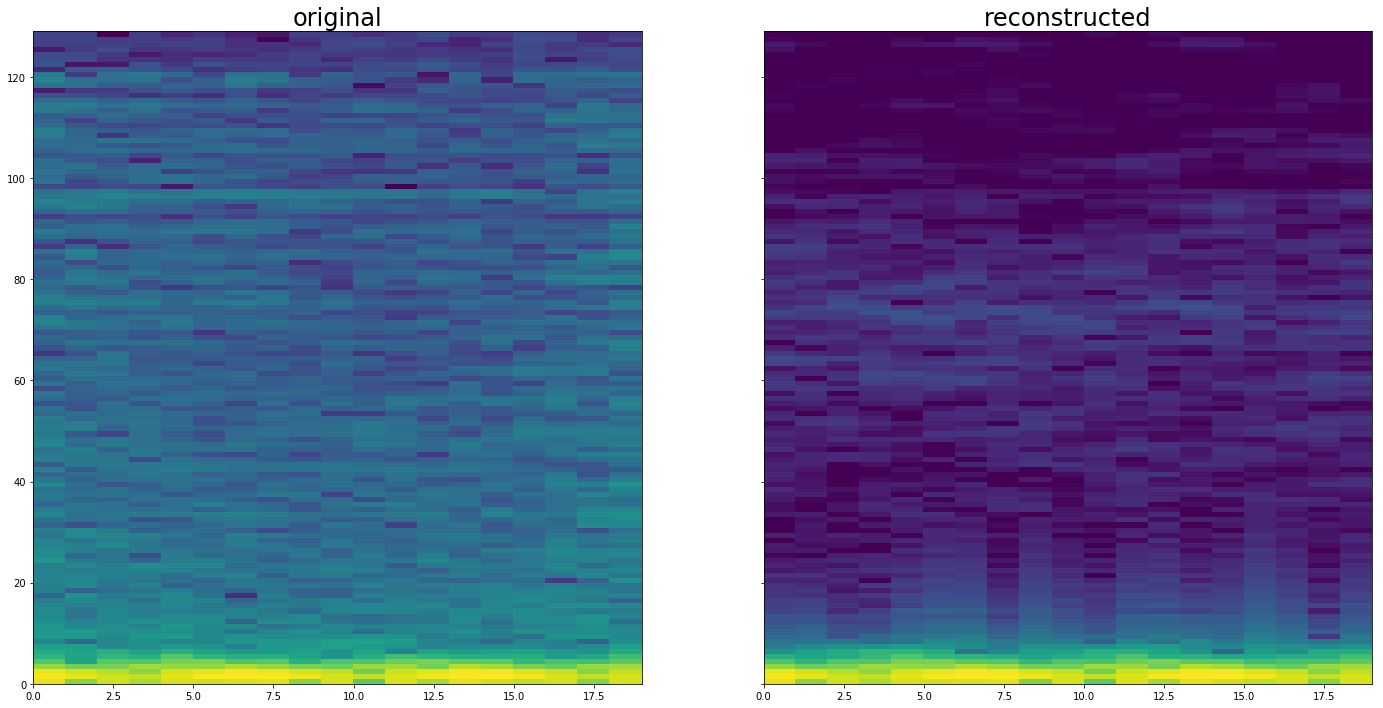

In [446]:
# testOn = 25

f, axarr = plt.subplots(1, 2, sharey='row', figsize=(24, 12))

#scaleeee
z_max = np.max(np.log10(np.abs(complexGenerated[testOn])))
z_min = np.min(np.log10(np.abs(complexGenerated[testOn])))


axarr[0].pcolormesh(np.log10(np.abs(complexGenerated[testOn]).transpose()), vmin=z_min, vmax=z_max)
axarr[0].set_title('original', size=24)
axarr[1].pcolormesh(np.log10(np.abs(complexOriginal[testOn]).transpose()), vmin=z_min, vmax=z_max)
axarr[1].set_title('reconstructed', size=24)


In [249]:
complexWithOriginalPhase = np.abs(complexGenerated) * np.exp(1.0j * np.angle(complexOriginal))

with tf.Session() as sess:
    originalPhaseTimeSignals = sess.run(tf_inverse_stft, feed_dict={stft_to_invert: complexWithOriginalPhase})


In [80]:
window_fn = functools.partial(window_ops.hann_window, periodic=True)
inverse_window = tf.contrib.signal.inverse_stft_window_fn(params.fftHopSize(),
                                       forward_window_fn=window_fn)
stft_to_invert = tf.placeholder(tf.complex64, shape=complexGenerated.shape, name='stft_to_invert')
tf_inverse_stft = tf.contrib.signal.inverse_stft(stfts=stft_to_invert, frame_length=params.fftWindowLength(), 
                                                          frame_step=params.fftHopSize(), window_fn=inverse_window)
with tf.Session() as sess:
    generatedTimeSignals = sess.run(tf_inverse_stft, feed_dict={stft_to_invert: complexGenerated})
    originalTimeSignals = sess.run(tf_inverse_stft, feed_dict={stft_to_invert: complexOriginal})

    

In [68]:
generatedTimeSignals.shape

(448, 1408)

In [132]:
reconstructedSignals = np.concatenate([audios[:len(generatedTimeSignals), :ending_sample_left_side], generatedTimeSignals[:, params.padding():-params.padding()], audios[:len(generatedTimeSignals), starting_sample_right_side:]], axis=1)
rec_original_signals = np.concatenate([audios[:len(generatedTimeSignals), :ending_sample_left_side], originalTimeSignals[:, params.padding():-params.padding()], audios[:len(generatedTimeSignals), starting_sample_right_side:]], axis=1)
# recPhase = np.concatenate([audios[:len(generatedTimeSignals), :ending_sample_left_side], originalPhaseTimeSignals[:, params.padding():-params.padding()], audios[:len(generatedTimeSignals), starting_sample_right_side:]], axis=1)

zeroedSignals = np.concatenate([audios[:len(generatedTimeSignals), :ending_sample_left_side], np.zeros([len(generatedTimeSignals), 1024], dtype=np.float32), audios[:len(generatedTimeSignals), starting_sample_right_side:]], axis=1)

In [353]:
reconstructedSignals.shape

(3904, 64000)

In [127]:
sr

16000

In [133]:
testOn = 15

print(_pavlovs_SNR(generatedTimeSignals[testOn], originalTimeSignals[testOn], onAxis=(0)))

# IPython.display.Audio(data=recPhase[testOn], rate=16000)

# librosa.output.write_wav("original_lstm.wav", rec_original_signals[testOn], sr)
librosa.output.write_wav("zeroed_lstm.wav", zeroedSignals[testOn], sr)
# librosa.output.write_wav("generated_lstm.wav", reconstructedSignals[testOn], sr)

IPython.display.Audio(data=rec_original_signals[testOn], rate=16000)
# IPython.display.Audio(data=zeroedSignals[testOn], rate=16000)
# IPython.display.Audio(data=reconstructedSignals[testOn], rate=16000)

29.922151565551758


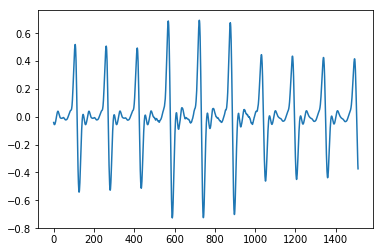

In [34]:
plt.plot(reconstructedSignals[testOn,ending_sample_left_side-500:starting_sample_right_side+500])

29.198997020721436


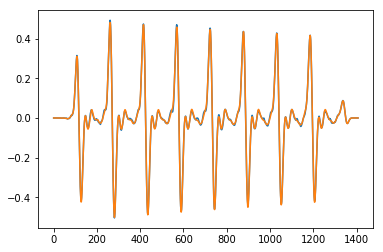

In [76]:
plt.plot(generatedTimeSignals[testOn, :])
plt.plot(originalTimeSignals[testOn, :])
# plt.plot(originalPhaseTimeSignals[testOn, 1230:1250])
print(_pavlovs_SNR(generatedTimeSignals[testOn], originalTimeSignals[testOn], onAxis=(0)))
# print(_pavlovs_SNR(originalPhaseTimeSignals[testOn], originalTimeSignals[testOn], onAxis=(0)))

5.9578001499176025


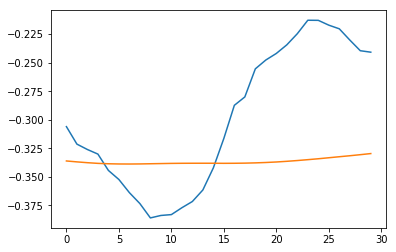

In [82]:
plt.plot(generatedTimeSignals[testOn, 1230:1260])
plt.plot(originalTimeSignals[testOn, 1230:1260])
print(_pavlovs_SNR(generatedTimeSignals[testOn], originalTimeSignals[testOn], onAxis=(0)))


In [202]:
generatedSpecs[0][10]==generatedSpecs[1][10]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [83]:
def _pavlovs_SNR(y_orig, y_inp, onAxis=(1,)):
    norm_y_orig = _squaredEuclideanNorm(y_orig, onAxis)
    norm_y_orig_minus_y_inp = _squaredEuclideanNorm(y_orig - y_inp, onAxis)
    return 10 * np.log10(norm_y_orig / norm_y_orig_minus_y_inp)

def _squaredEuclideanNorm(vector, onAxis=(1,)):
    squared = np.square(vector)
    summed = np.sum(squared, axis=onAxis)
    return summed

SNRs = _pavlovs_SNR(originalTimeSignals, generatedTimeSignals, onAxis=(1,))
print(np.mean(SNRs))
print(np.std(SNRs))
print(np.max(SNRs))
print(np.min(SNRs))


21.45452
12.077084
41.247314
-7.7961106


In [487]:
SNRs = _pavlovs_SNR(originalTimeSignals, generatedTimeSignals, onAxis=(1,))
print(np.mean(SNRs))
print(np.std(SNRs))
print(np.max(SNRs))
print(np.min(SNRs))


5.956699
2.304683
22.789444
-5.8636456


In [296]:
np.where(SNRs<10)

(array([ 156,  157,  158, ..., 3901, 3902, 3903], dtype=int64),)

In [47]:
pSNRs = _pavlovs_SNR(originalPhaseTimeSignals, originalTimeSignals, onAxis=(1,))
print(np.mean(pSNRs))



14.469685


In [295]:
print(np.mean(_pavlovs_SNR(generatedTimeSignals[1000:], originalTimeSignals[1000:], onAxis=(1,))))


14.006761


c:\users\andres\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


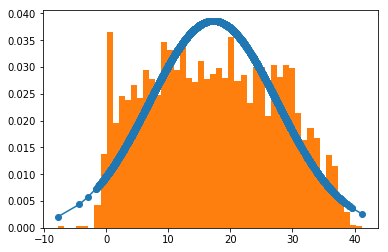

In [454]:
sorted_SNR = sorted(SNRs)

import scipy.stats as stats
fit = stats.norm.pdf(sorted_SNR, np.mean(sorted_SNR), np.std(sorted_SNR))  #this is a fitting indeed

plt.plot(sorted_SNR,fit,'-o')

plt.hist(sorted_SNR, 50, normed=True)    ;

c:\users\andres\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


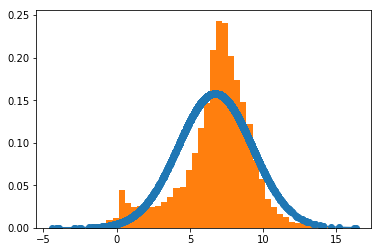

In [334]:
sorted_SNR = sorted(SNRs)

import scipy.stats as stats
fit = stats.norm.pdf(sorted_SNR, np.mean(sorted_SNR), np.std(sorted_SNR))  #this is a fitting indeed

plt.plot(sorted_SNR,fit,'-o')

plt.hist(sorted_SNR, 50, normed=True);   

In [33]:
print(np.where(SNRs<-10))

(array([ 255,  256,  257,  260,  271,  709,  945,  961,  963,  964,  971,
        979,  980,  981, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020,
       1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031,
       1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042,
       1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053,
       1949, 1952, 2036, 2039, 2040, 2042, 2043, 2045, 2047, 2048, 2633,
       2634, 2637, 2638, 2639, 2640, 2943, 2944, 2945, 2946, 2948, 2949,
       2950, 2951, 2952, 2953, 3438, 3439, 3451, 3452, 3453, 3454, 3851,
       3852, 3859, 3860, 3861, 3863, 3865, 3870, 3874, 3877, 3879, 3881,
       3882, 3885, 3886, 3889, 3890, 3894, 3895, 3896, 3897, 3901],
      dtype=int64),)


In [ ]:
import copy
def griffinLim(stfts, passes, params):
    absolute_values = np.abs(stfts)
    window_fn = functools.partial(window_ops.hann_window, periodic=True)
    inverse_window = tf.contrib.signal.inverse_stft_window_fn(params.fftHopSize(),
                                           forward_window_fn=window_fn)
    stft_to_invert = tf.placeholder(tf.complex64, shape=realSignals.shape, name='stft_to_invert')
    tf_inverse_stft = tf.contrib.signal.inverse_stft(stfts=stft_to_invert, frame_length=params.fftWindowLength(), 
                                                              frame_step=params.fftHopSize(), window_fn=inverse_window)
    tf_forward_stft = tf.contrib.signal.stft(signals=tf_inverse_stft, frame_length=params.fftWindowLength(), 
                                          frame_step=params.fftHopSize(), window_fn=window_fn)
    with tf.Session() as sess:
        for i in range(passes):
            realSignals = absolute_values + 1.0j*np.imag(realSignals)
            feed_dict = {stft_to_invert: realSignals}
            realSignals = sess.run(tf_forward_stft, feed_dict=feed_dict)
        feed_dict = {stft_to_invert: realSignals}
        return sess.run(tf_inverse_stft, feed_dict=feed_dict)